In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize, root_scalar, minimize_scalar
from scipy.linalg import solve_discrete_lyapunov
from scipy.signal import correlate, hilbert


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("default", category=RuntimeWarning)


# Function Implementation

In [2]:
def rot(w):
    return np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]], dtype=np.float64)

## Likelihoods

In [3]:
def likelihood(x, xm, Pinv, dN, mu_c, beta):
    dot2 = (-1/2)*np.linalg.multi_dot([(x - xm).T, Pinv, x - xm])
    L = dN*(mu_c + beta*x[0]) - np.exp(mu_c + beta*x[0]) + dot2
    return -L

def jacobian(x, xm, Pinv, dN, mu_c, beta):
    jac = -np.dot(Pinv, x - xm)
    jac[0] += (dN - np.exp(mu_c + beta*x[0]))*beta
    return  -jac

def hessian(x, xm, Pinv, dN, mu_c, beta):
    hess = -Pinv.copy()
    hess[0,0] -= np.exp(mu_c + beta*x[0])*np.power(beta, 2)
    return -hess

In [4]:
def max_L(x0, xp_k, Pinv_k, y, mu_c, beta, method='trust-krylov'):
    return minimize(likelihood, xp_k, args=(xp_k, Pinv_k, y, mu_c, beta),
                           jac=jacobian, hess=hessian, method = method)

## KF

In [5]:
def KF_step(x_m_k1, P_m_k1, alpha, sigma, R, mu, beta, y_k, method='trust-krylov'):
    #Prediction Step
    xp_k = alpha * np.dot(R, x_m_k1)
    Pp_k = np.power(alpha, 2) * np.linalg.multi_dot([R, P_m_k1, R.T]) + sigma*np.eye(2)

    
    Pinv_k = np.linalg.pinv(Pp_k)

    # Measurement step : maximizing likelihood function
    # Using x_{k|k-1} as initial estimate for minimize function
    res = max_L(x_m_k1, xp_k, Pinv_k, y_k, mu, beta, method=method)

    if not res.success:
        print("Estimation of $x_{m, k}$  failed to converge : " + res.message)
        raise AssertionError("Estimation of $x_{m, k}$  failed to converge : " + res.message)

    # eps = 1e-6
    # hess_reg = res.hess + eps * np.eye(res.hess.shape[0])
    # Pm_k = np.linalg.pinv(hess_reg)
    Pm_k = np.linalg.pinv(res.hess)# Negative not required because hessian function minimizes the "negative likelihood".
    return xp_k, res.x, Pp_k, Pm_k


In [6]:
def backward_pass(alpha, R, x_p, x_m, P_p, P_m, K):
    AG = np.zeros((2,2,K))
    x_b = np.zeros((2,K))
    P_b = np.zeros((2,2,K))
    x_b[:, -1] = x_m[:, -1].copy()
    P_b[:, :, -1] = P_m[:, :, -1].copy()
    for k in range(K-1, 0, -1):
        A_k1 = np.linalg.multi_dot([P_m[:, :, k-1], alpha*R.T, np.linalg.pinv(P_p[:, :, k])])
        AG[:, :, k-1] = A_k1

        x_b[:, k-1] = x_m[:, k-1] + np.dot(A_k1, x_b[:, k] - x_p[:, k])
        P_b[:, :, k-1] = P_m[:, :, k-1] + np.linalg.multi_dot([A_k1, P_b[:, :, k] - P_p[:, :, k], A_k1.T])

    return x_b, P_b, AG

In [7]:
def KFilter(x0, y, mu, beta, sigma, alpha, F, Fs, K=None):

    if not K:
        K = y.shape[1]

    omega = 2*np.pi*F/Fs
    R = rot(omega)

    x_p = np.zeros((2,K))
    x_m = np.zeros((2,K))

    P_p = np.zeros((2,2,K))
    P_m = np.zeros((2,2,K))

    P_m[:, :, 0] = (sigma/(1 - np.power(alpha, 2)))*np.eye(2) #steady state calculation of P_m as an estimate of P_0|0
    x_m[:, 0] = x0.copy()

    #Forward Pass : Kalman Filter
    for k in range(1, K):
        xp_k, xm_k, Pp_k, Pm_k = KF_step(x_m[:, k-1], P_m[:, :, k-1],
                                                 alpha, sigma, R, mu, beta, y[k], method='trust-krylov')
        x_p[:, k], P_p[:, :, k], x_m[:, k], P_m[:, :, k] = xp_k, Pp_k, xm_k, Pm_k

    #Backward Pass
    x_b, P_b, AG = backward_pass(alpha, R, x_p, x_m, P_p, P_m, K)

    return x_p, x_m, x_b, P_p, P_m, P_b, AG


##  EM Funcs

In [8]:
def E_step(x_b, P_b, AG, K, beta):
    
    A = P_b[:, :, :-1].sum(axis=-1) + np.dot(x_b[:, :-1], x_b[:, :-1].T)
    B = np.matmul(np.transpose(P_b[:, :, 1:], axes=(2,0,1)), np.transpose(AG[:, :, :-1], axes=[2,1,0])).sum(axis=0) # Verified formula
    B += np.dot(x_b[:, 1:], x_b[:, :-1].T)
    C = P_b[:, :, 1:].sum(axis=-1) + np.dot(x_b[:, 1:], x_b[:, 1:].T)

    mu_exp = np.exp(beta*x_b[0, :] + np.power(beta,2)*P_b[0,0, : ]/2).sum()
    return A, B, C, mu_exp

In [9]:
def M_step(A, B, C, mu_exp, dN, K, a0 = 120, b0 = 0.121, mu0 = -3.2, tau = 0.05):

    omega_h = np.arctan2(B[1,0] - B[0,1], np.trace(B))
    alpha_h = (np.trace(B)*np.cos(omega_h) + (B[1,0] - B[0,1])*np.sin(omega_h)) / np.trace(A) ## make it rt(B) - new func
    # sigma_h = (np.trace(C) - np.power(alpha_h, 2)*np.trace(A))/(2*K)
    sigma_h = (np.trace(C) - np.power(alpha_h, 2)*np.trace(A) + 2*b0)/(2*(K+a0+1))

    # exp_sum = np.exp(beta*x_b[0, :] + np.power(beta,2)*P_b[0,0, : ]/2).sum()
    # mu_h = np.log(np.sum(dN)) - np.log(mu_exp)
    mu_h = mu_min_update(mu_exp, mu0, tau, dN)

    return mu_h, alpha_h, omega_h, sigma_h

In [10]:
def mu_prior(mu, S, mu0, tau, dN):
    return S*np.exp(mu) + mu/tau - dN.sum() - mu0/tau

def mu_prior_update(S, mu0, tau, dN):
    res = root_scalar(mu_prior, args=(S, mu0, tau, dN), method='newton', x0=mu0)
    if res.converged:
        return res.root
    else:
        raise RuntimeError("Root finding did not converge.")

def mu_min(mu, S, mu0, tau, dN):
    return -(mu*dN.sum() - np.exp(mu)*S - ((mu - mu0)**2)/(2*tau))
def mu_min_update(S, mu0, tau, dN, bounds = (-10, 10)):
    result = minimize_scalar(mu_min, args=(S, mu0, tau, dN), bounds=bounds, method='bounded')
    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization did not converge.")

In [35]:
# itr = 3
# At, Bt, Ct, mu_expt = E_step(E_steps['x_b'][itr], E_steps['P_b'][itr], E_steps['BG'][itr], N, beta)
# mut, alphat, omegat, sigmat = M_step(At, Bt, Ct, mu_expt, y, N)
# for i,v in zip(params.columns, [mut, alphat, omegat, sigmat]):
#     print(i,v)

In [ ]:
# params.iloc[itr+1]

In [12]:
def run_EM(y, x0, mu0, beta, sigma0, alpha0, F0, Fs, iters = 100, method='trust-krylov', log_file = 'params_log.csv'):

    K = y.shape[-1]
    
    omega0 = 2*np.pi*F0/Fs
    const_mu = mu0
    const_F = F0
    const_alpha = alpha0
    const_sigma = sigma0
    

    params = pd.DataFrame(columns=['$\\mu$', '$\\alpha$', '$\\omega$', '$\\sigma^2$'])
    params.loc[0, :] = [mu0, alpha0, omega0, sigma0]

    error_log = pd.DataFrame(columns = ['n_iter', 'x0', 'mu_h', 'alpha_h', 'omega_h', 'sigma_h', 'msg'])

    E_steps = {'x_p': [],'x_m': [],'x_b': [],'P_p': [],'P_m': [],'P_b': [], 'BG':[], 'A':[], 'B':[], 'C':[]}
    inits = pd.DataFrame(columns = ['n_iter', 'x0', 'mu0', 'alpha0', 'F0', 'omega0', 'sigma0'])
    for itr in range(1, iters+1):
        print(itr, end=' ')

        try:
            # mu0 = const_mu
            # alpha0 = const_alpha
            # F0 = const_F
            # sigma0 = const_sigma
            
            # Filtering to get x and P estimates
            inits.loc[itr, :] = [itr, x0, mu0, alpha0, F0, omega0, sigma0]
            x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, BG = KFilter(x0, y, mu0, beta, sigma0, alpha0, F0, Fs, K)

            for k,v in zip(['x_p','x_m','x_b','P_p','P_m','P_b', 'BG'],
                           [x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, BG]):
                E_steps[k].append(v)

            # Maximizing to update param values
            # E-step
            A,B,C, mu_exp = E_step(x_smooth, P_smooth, BG, K, beta)

            for k,v in zip(['A', 'B', 'C'], [A, B, C]):
                E_steps[k].append(v)

            # M-step
            mu_h, alpha_h, omega_h, sigma_h = M_step(A, B, C, mu_exp, y, K)
            params.loc[itr, :] = [mu_h, alpha_h, omega_h, sigma_h]

            params.to_csv(log_file)

            #Update for next iter
            F0 = omega_h/(2*np.pi/Fs) # since filter takes in F and not omega
            mu0, alpha0, omega0, sigma0 = mu_h, alpha_h, omega_h, sigma_h
            x0 = x_smooth[:, 0]
        except AssertionError as err:
            error_log.loc[error_log.shape[0], :] = [itr, x0, mu0, alpha0, omega0, sigma0, err.__str__()]

    return params, E_steps, [mu_h, alpha_h, F0, omega_h, sigma_h], error_log, inits





# Test EM

In [13]:
def get_params(N = 1000, random = True, plot = False, print_params = False):

    # Randomly choose input constants that fit expected criteria for observation signal
    if random:
        rng = np.random.default_rng()
        mu = 2*rng.random() - 5  # range (-5, -3)
        beta = 8 # beta is modified below to ensure that y spikes approx comes from peaks of obs; beta range (1, 21)
        alpha = 0.248*rng.random() + 0.75 # range (0.75, 0.999)
        F = 100*rng.random() + 3 # range (3, 103)

        # Keeping these fixed for now
        sigma = 0.001
        Fs = 1000

        omega = 2*np.pi*F/Fs
        R = rot(omega)

        # Inputs
        u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
        X = np.zeros_like(u)
        X[:, 0] = u[:, 0]
        for k in range(1,N):
            X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]
        obs = np.exp(mu + beta*X[0])

        # Ensuring obs is in the *right* range of ~ (0, 1) so np.exp(mu + beta*x[0]) isn't too large
        while obs.max() < 0.75:
            if beta > 20:
                break
            beta += 1
            obs = np.exp(mu + beta*X[0])

        while obs.max() >= 1.05:
            if beta < 2:
                break
            beta -= 1
            obs = np.exp(mu + beta*X[0])

        # y spikes whenever obs > random_number
        y = np.zeros_like(obs)
        for i, yi in enumerate(obs):
            if yi > rng.random():
                y[i] = 1

    #fixed parameter values
    else:
        rng = np.random.default_rng(4)
        mu = -4
        beta = 4.5
        sigma = 0.001
        alpha = 0.99
        F = 50
        Fs = 1000

        omega = 2*np.pi*F/Fs
        R = rot(omega)

        u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
        X = np.zeros_like(u)
        X[:, 0] = u[:, 0]
        for k in range(1,N):
            X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]
        obs = np.exp(mu + beta*X[0])
        y = np.zeros_like(obs)
        for i, yi in enumerate(obs):
            if yi > rng.random():
                y[i] = 1

    if plot:
        fig, ax = plt.subplots(figsize=(14,4))
        ax.vlines(np.where(y)[0], ymin=0, ymax = 1, ls='--', color='grey', lw=0.85)
        ax.plot(obs)
        ax.set_xlabel('Samples', fontsize=12)
        ax.set_ylabel('$e^{\\mu + \\beta x_{1}}$')
        ax.set_title(f'Firing rate : {y.mean()*Fs} Hz', fontsize=12)

    if print_params:
        print(f'X dims : {X.shape}')
        print(f'y dims : {y.shape}')
        for name, var in zip(['N', 'Fs', 'alpha', 'F', 'omega', 'sigma', 'mu', 'beta', 'R'],
                             [N, Fs, alpha, F, omega, sigma, mu, beta, R]):
            print(f'{name} : {np.round(var, 4)}')

    return X, y, N, Fs, alpha, F, omega, R, sigma, mu, beta


## Trial with N = 10k, mu - constant

X dims : (2, 5000)
y dims : (5000,)
N : 5000
Fs : 1000
alpha : 0.99
F : 50
omega : 0.3142
sigma : 0.001
mu : -4
beta : 4.5
R : [[ 0.9511 -0.309 ]
 [ 0.309   0.9511]]


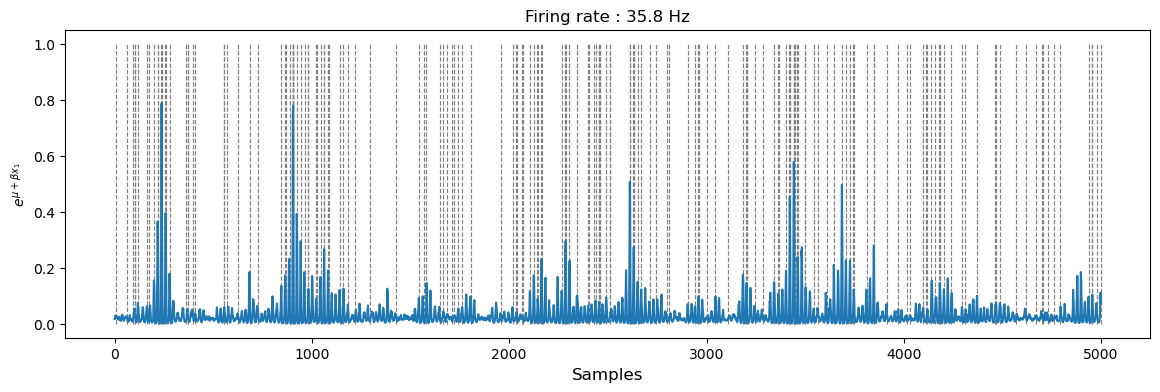

In [108]:
X, y, N, Fs, alpha, F, omega, R, sigma, mu, beta = get_params(N=5000, random = False, print_params=True, plot=True)

In [109]:
mu, beta, sigma, alpha, F


(-4, 4.5, 0.001, 0.99, 50)

In [110]:
# mu0 = -
sigma0 = 0.00095
alpha0 = 0.9
F0 = 45

x0 = X[:, 0]

In [111]:
params, E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu, beta, sigma, alpha, F, Fs,
                                                                           iters = 30, method='trust-krylov')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

In [98]:
ch_params, ch_E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu, beta, sigma0, alpha0, F0, Fs,
                                                                           iters = 30, method='trust-krylov')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

In [100]:
ch2_params, ch2_E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu_est, beta, sigma_est, alpha_est, F_est, Fs,
                                                                           iters = 30, method='trust-krylov')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

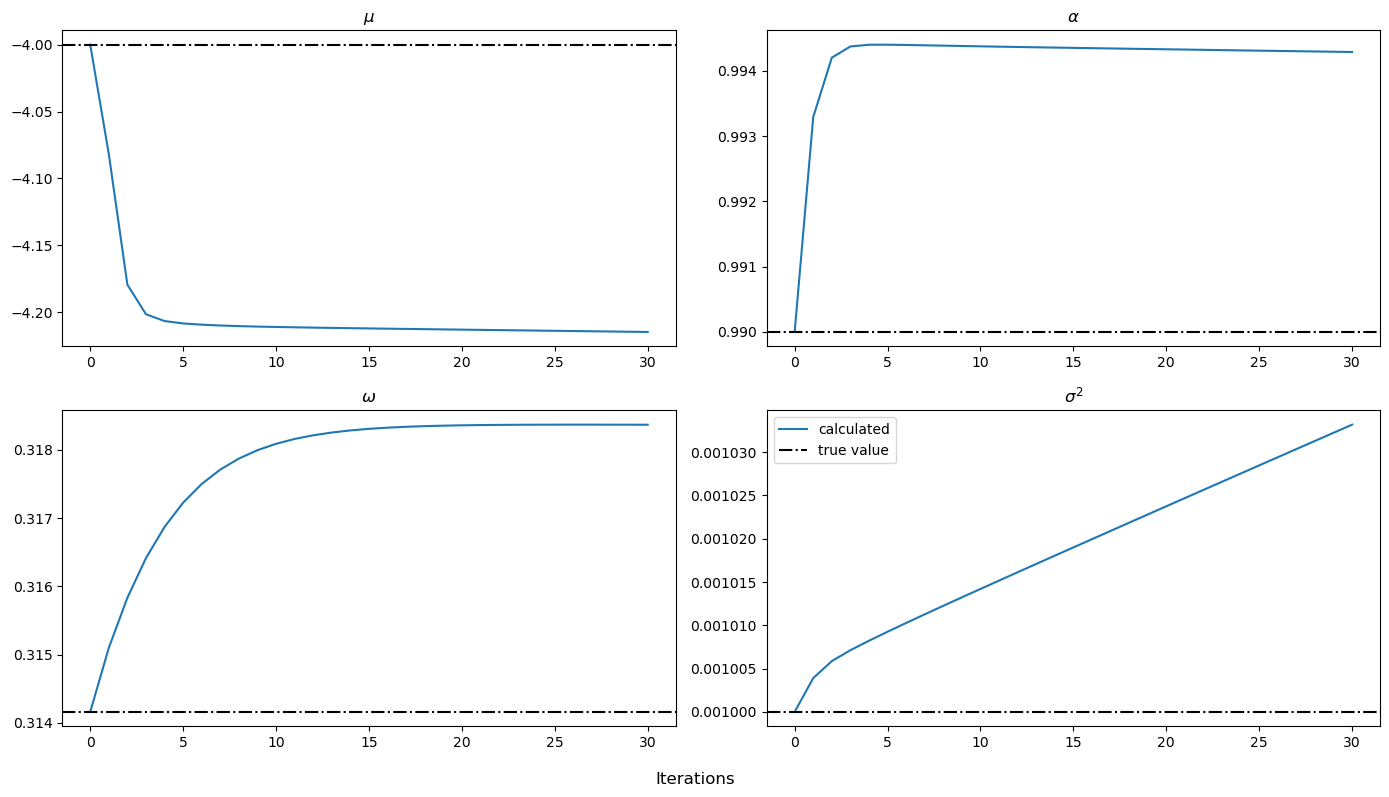

In [112]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


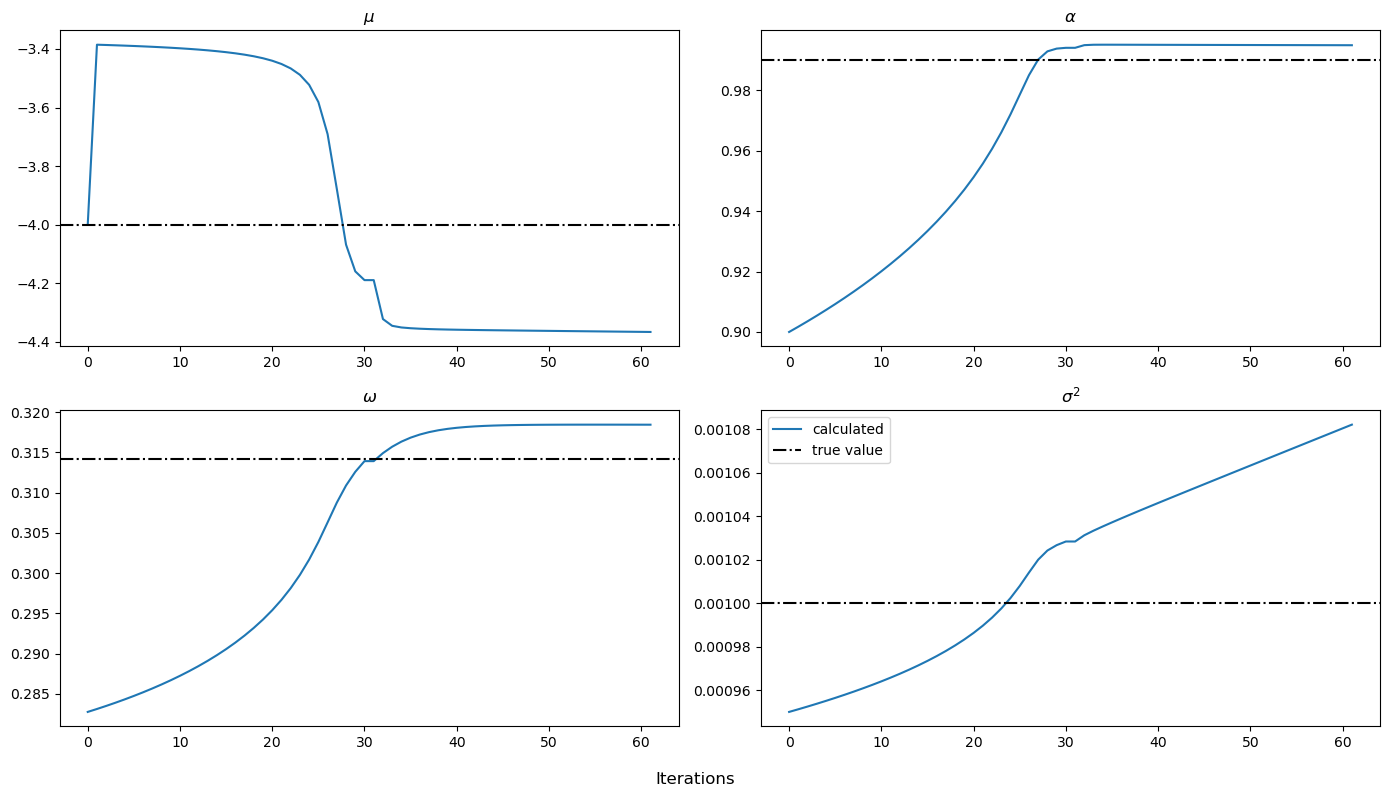

In [101]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
params_all = pd.concat([ch_params, ch2_params], ignore_index=True)
for cols, ax, true_param, ix in zip(ch_params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params_all.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


In [34]:
mu_est, sigma_est, alpha_est, F_est, true_params

(np.float64(-5.0971842710712485),
 np.float64(0.0019775090749457433),
 np.float64(0.9707799625601273),
 np.float64(11.924655579313962),
 [-4.5, 0.973, 0.06283185307179587, 0.001])

In [35]:
params2, E_steps2, [mu_est2, alpha_est2, F_est2, omega_est2, sigma_est2], error_log2, inits2 = run_EM(y, x0,
                                                                           mu, beta, sigma_est, alpha_est, F_est, Fs,
                                                                           iters = 1000, method='trust-krylov', log_file='params2_log.csv')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

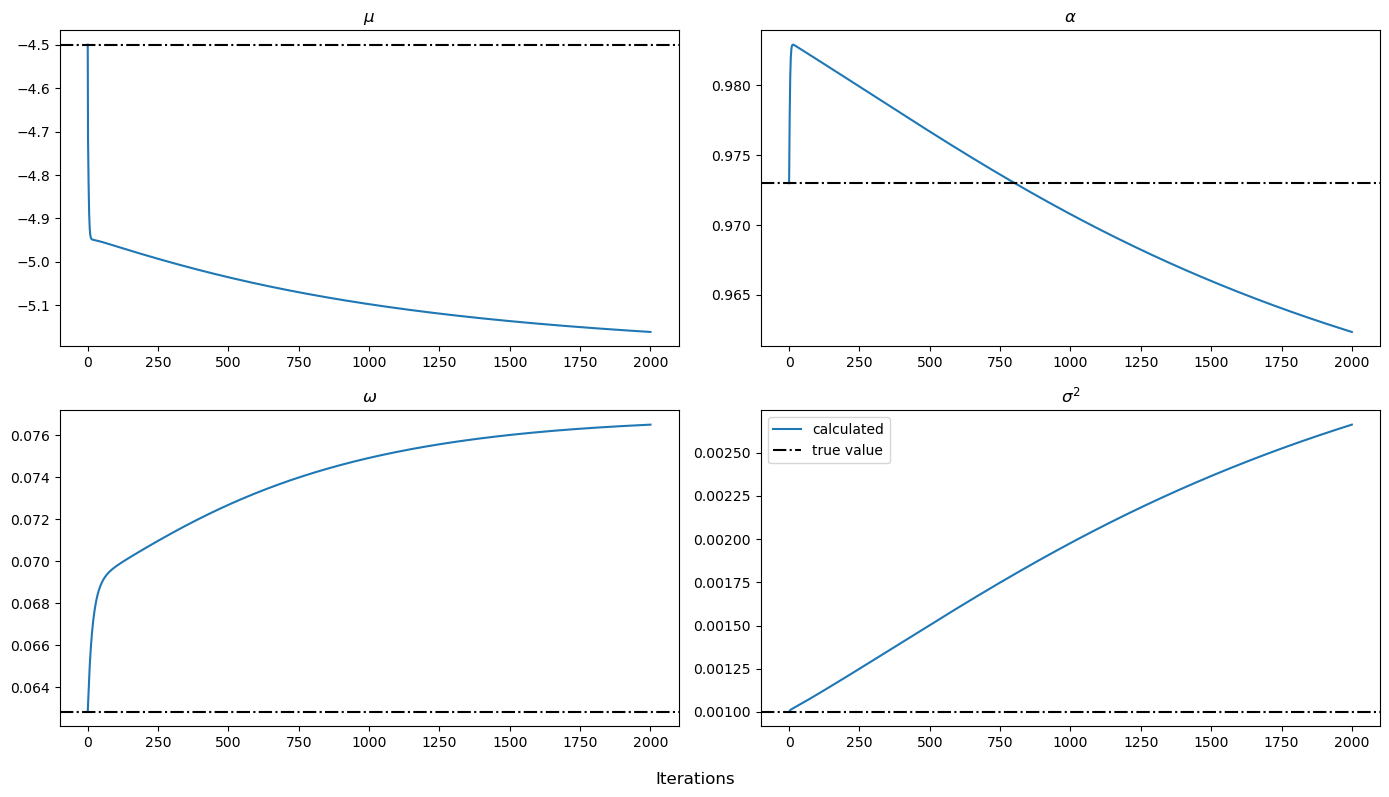

In [83]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
params_all = pd.concat([params, params2.loc[1:]], ignore_index=True)
for cols, ax, true_param, ix in zip(params_all.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params_all.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


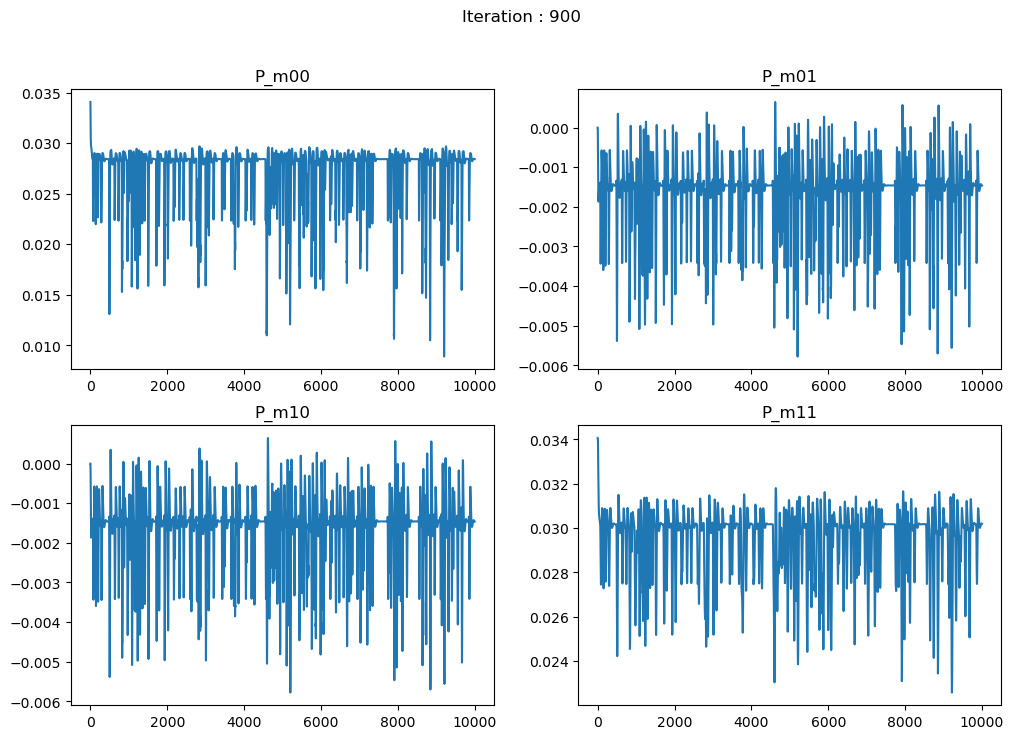

In [70]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 900
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

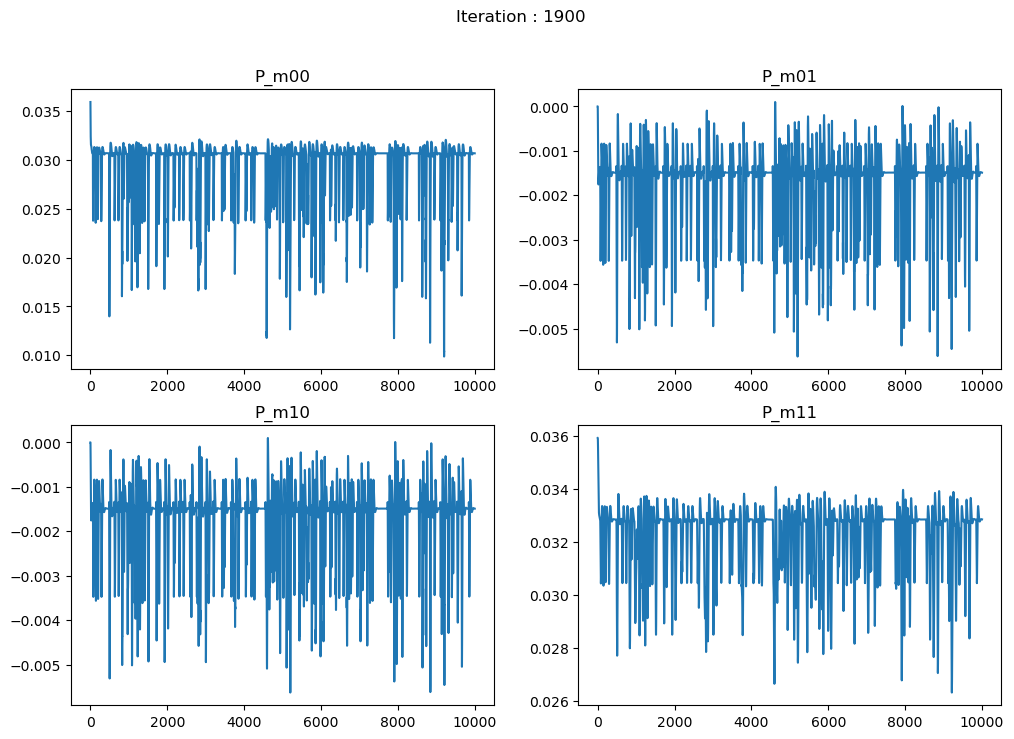

In [72]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 900
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps2[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {1000+itr}')
plt.show()

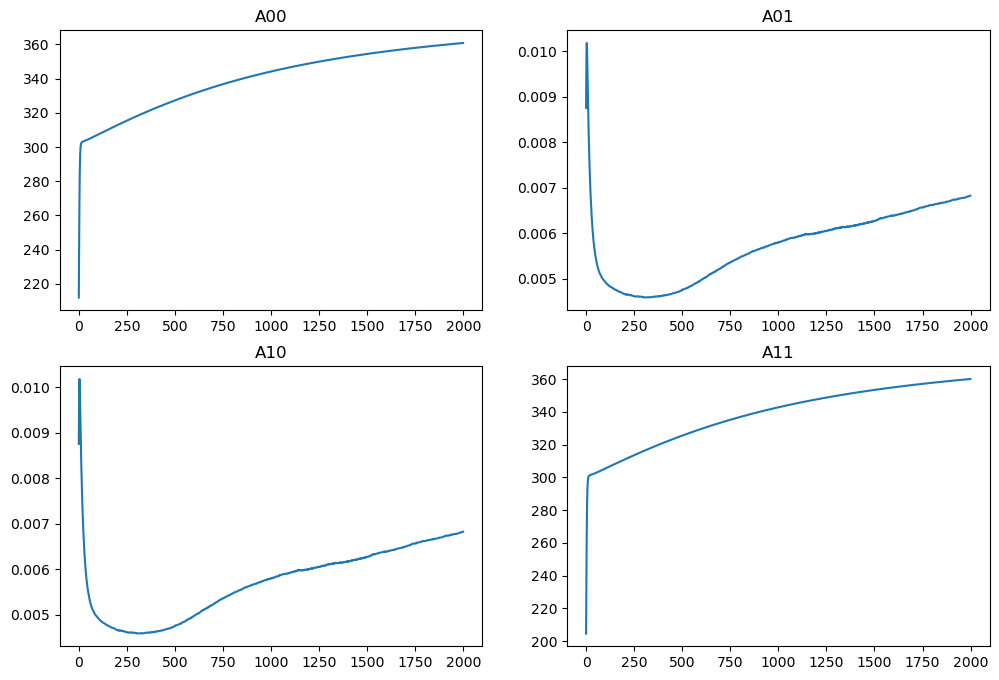

In [88]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'A'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.concatenate([E_steps[which_E], E_steps2[which_E]])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


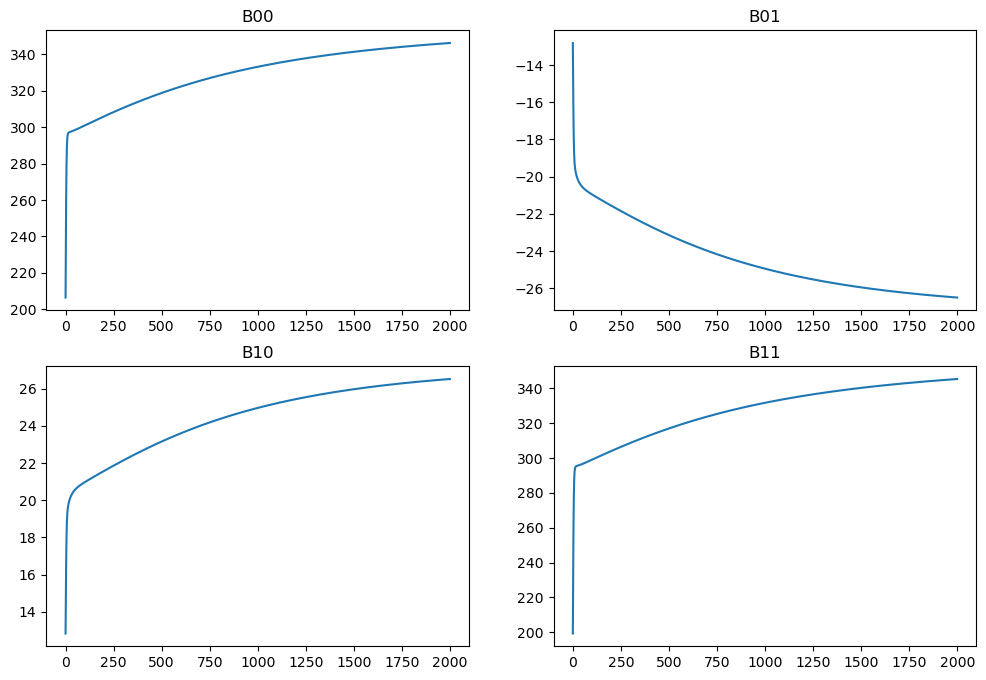

In [84]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'B'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.concatenate([E_steps[which_E], E_steps2[which_E]])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


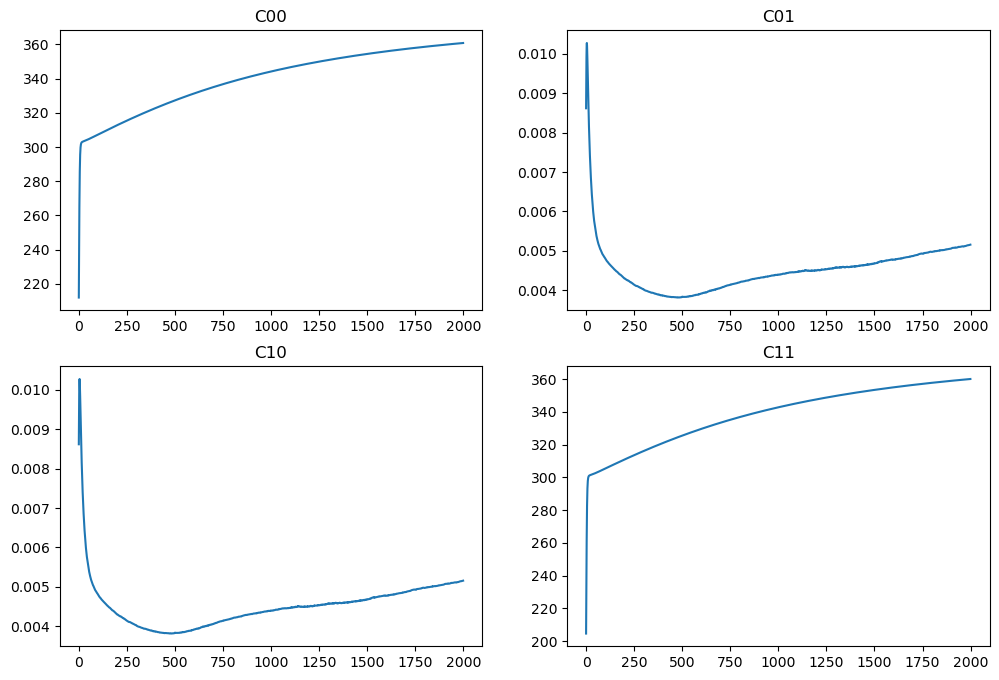

In [82]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'C'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.concatenate([E_steps[which_E], E_steps2[which_E]])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


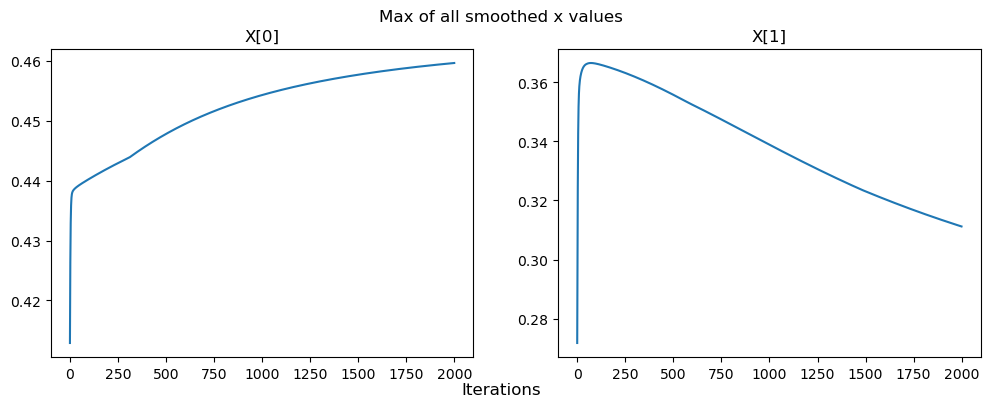

In [99]:
xbs = np.concatenate([E_steps['x_b'], E_steps2['x_b']])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.plot(xbs[:, 0, :].max(axis=1))
ax1.set_title('X[0]')
ax2.plot(xbs[:, 1, :].max(axis=1))
ax2.set_title('X[1]')
fig.suptitle('Max of all smoothed x values')
fig.supxlabel('Iterations')
plt.show()

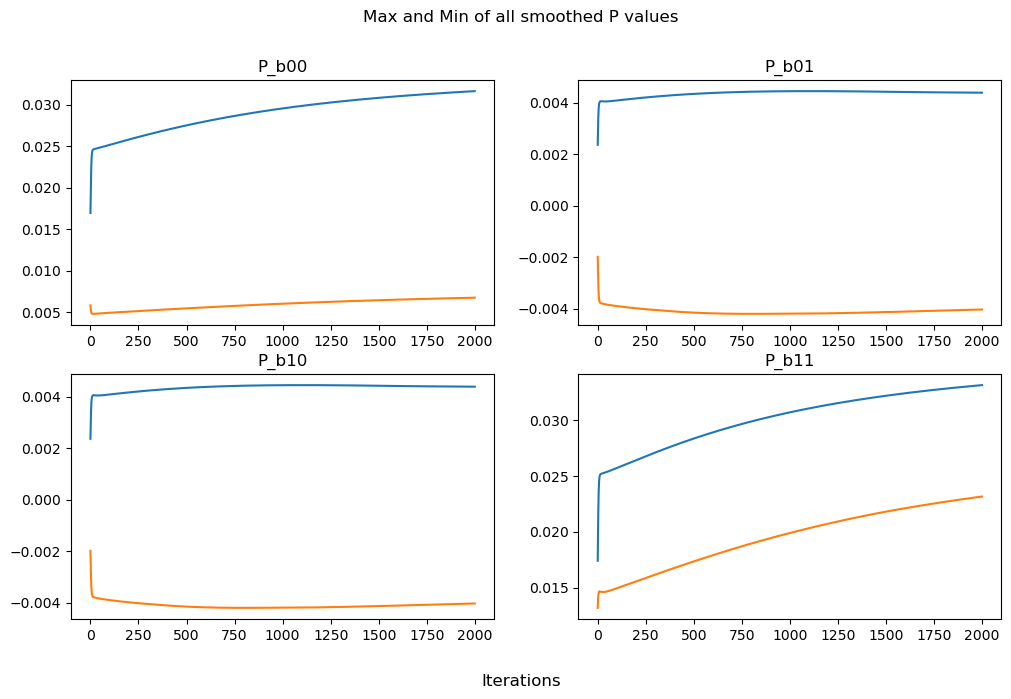

In [102]:
# Pbs = np.concatenate([E_steps['P_b'], E_steps2['P_b']])
fig, axs = plt.subplots(2,2, figsize=(12, 7))

for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(Pbs[:, xx, yy, :].max(axis=1))
        rows.plot(Pbs[:, xx, yy, :].min(axis=1))
        rows.set_title('P_b' + str(xx)+str(yy))

fig.suptitle('Max and Min of all smoothed P values')
fig.supxlabel('Iterations')
plt.show()

Text(0.5, 1.0, 'X0, itr = 2')

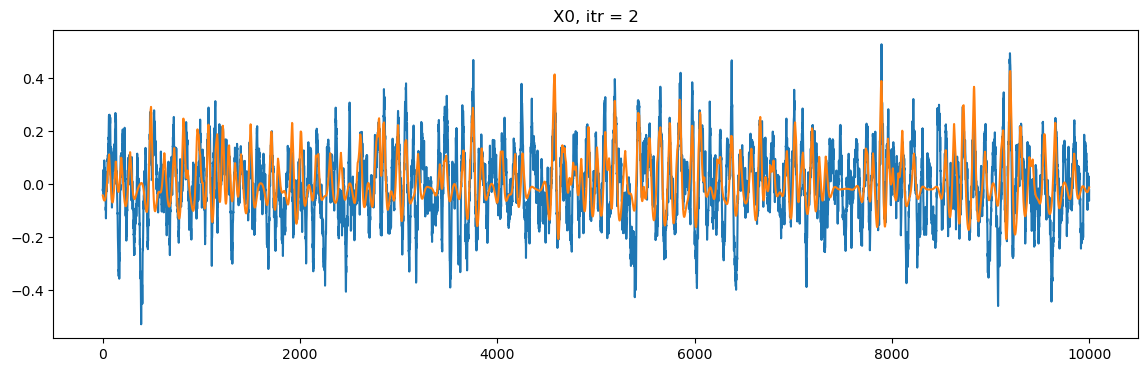

In [116]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][2][0])
plt.title('X0, itr = 2')
plt.show()

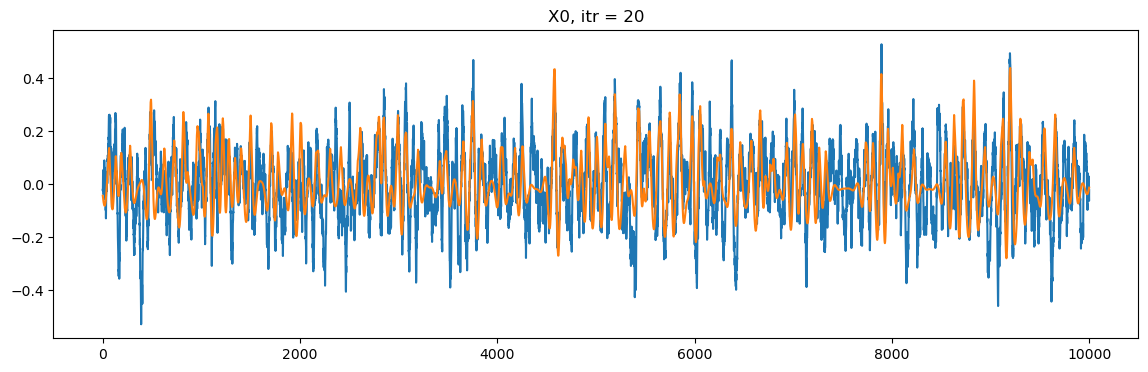

In [117]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][20][0])
plt.title('X0, itr = 20')
plt.show()

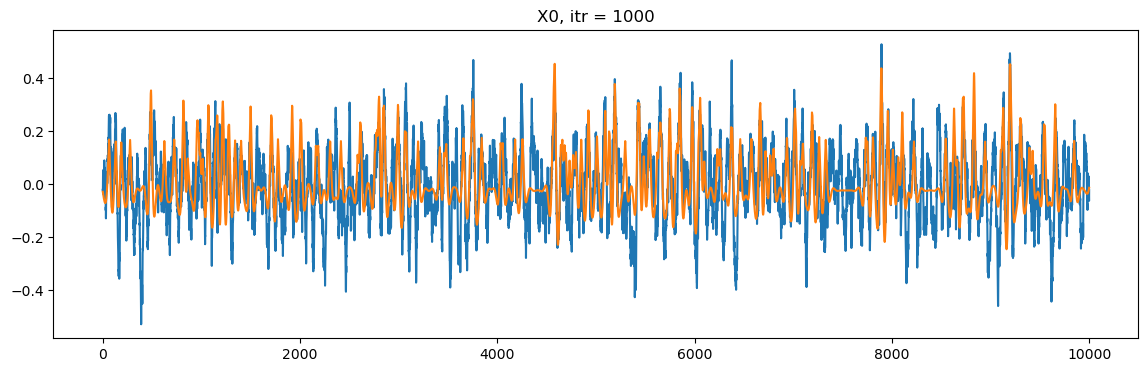

In [118]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][-1][0])
plt.title('X0, itr = 1000')
plt.show()

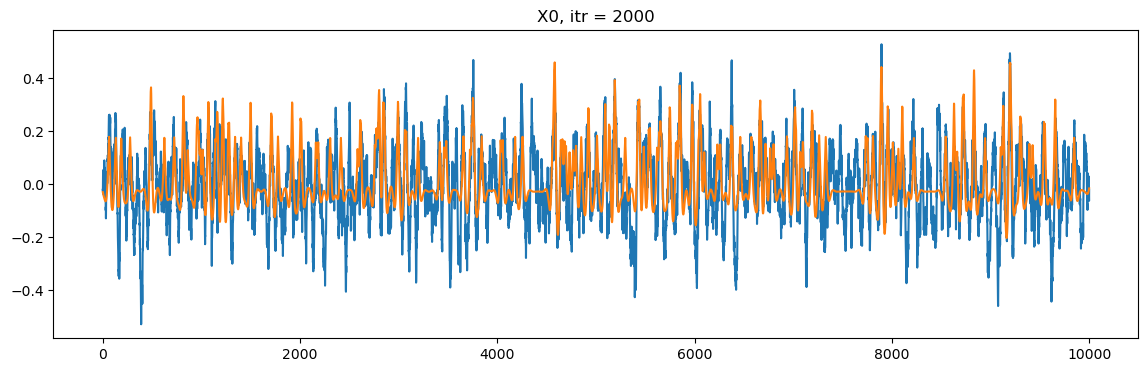

In [119]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps2['x_b'][-1][0])
plt.title('X0, itr = 2000')
plt.show()

## Test N = 5k, no const

X dims : (2, 5000)
y dims : (5000,)
N : 5000
Fs : 1000
alpha : 0.9544
F : 86.6925
omega : 0.5447
sigma : 0.001
mu : -3.1518
beta : 7
R : [[ 0.8553 -0.5182]
 [ 0.5182  0.8553]]


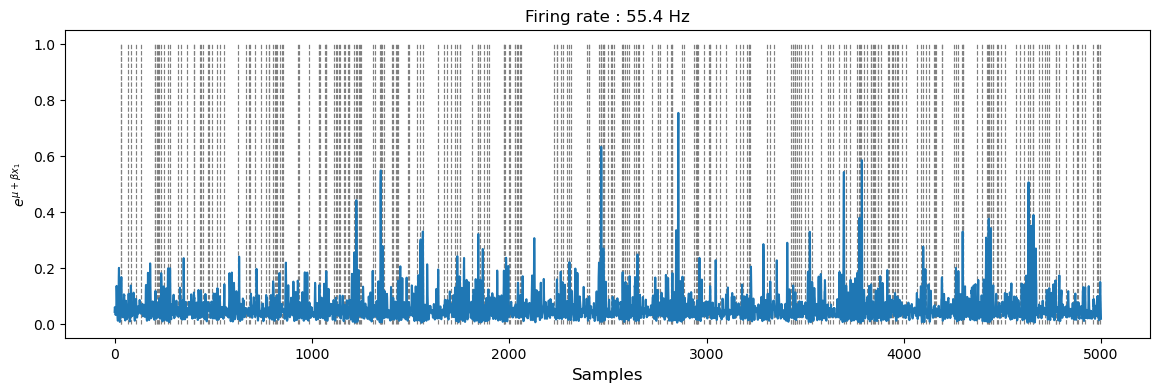

In [31]:
X, y, N, Fs, alpha, F, omega, R, sigma, mu, beta = get_params(N=5000, random = True, print_params=True, plot=True)

In [32]:
print(f'{mu, alpha, omega, sigma, F, beta}')


(-3.1518186515890863, 0.9543868625221291, 0.5447052192372602, 0.001, 86.69252816956454, 7)


In [33]:
# mu0 = -8
# sigma0 = 0.001
# alpha0 = 0.5
# F0 = 5

x0 = X[:, 0]

In [34]:
params, E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu, beta, sigma, alpha, F, Fs,
                                                                           iters =200, method='trust-krylov',
                                                                                            log_file='mu-sig_priors.csv')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

In [47]:
# params2 = pd.read_csv('params2_log.csv', index_col=0)
# params3 = pd.concat([params, params2.iloc[70:]], ignore_index = True)
# params2

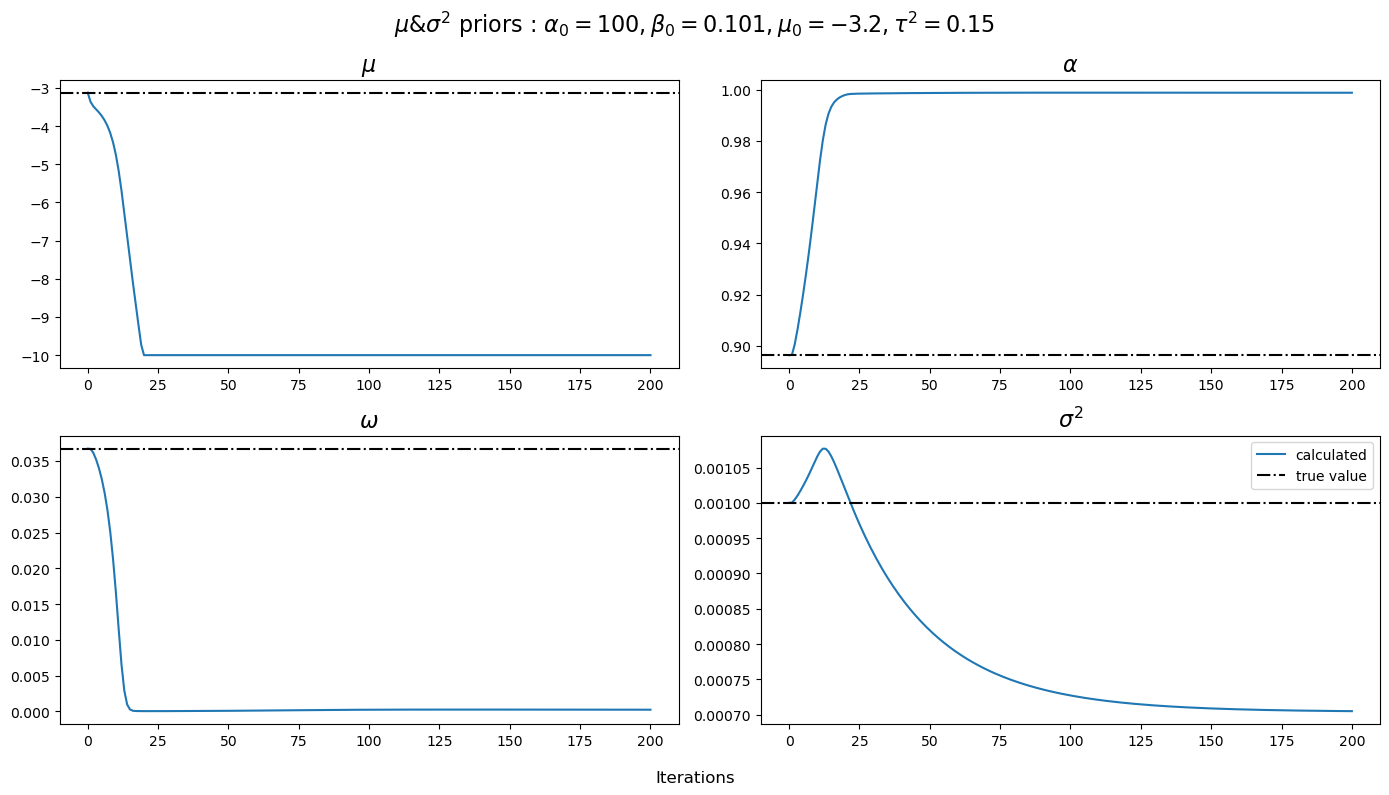

In [31]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols, fontsize=16)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.suptitle('$\\mu & \\sigma^2$ priors : $\\alpha_0=100, \\beta_0=0.101, \\mu_0=-3.2, \\tau^2=0.15$', fontsize=16)
fig.tight_layout()
plt.show()


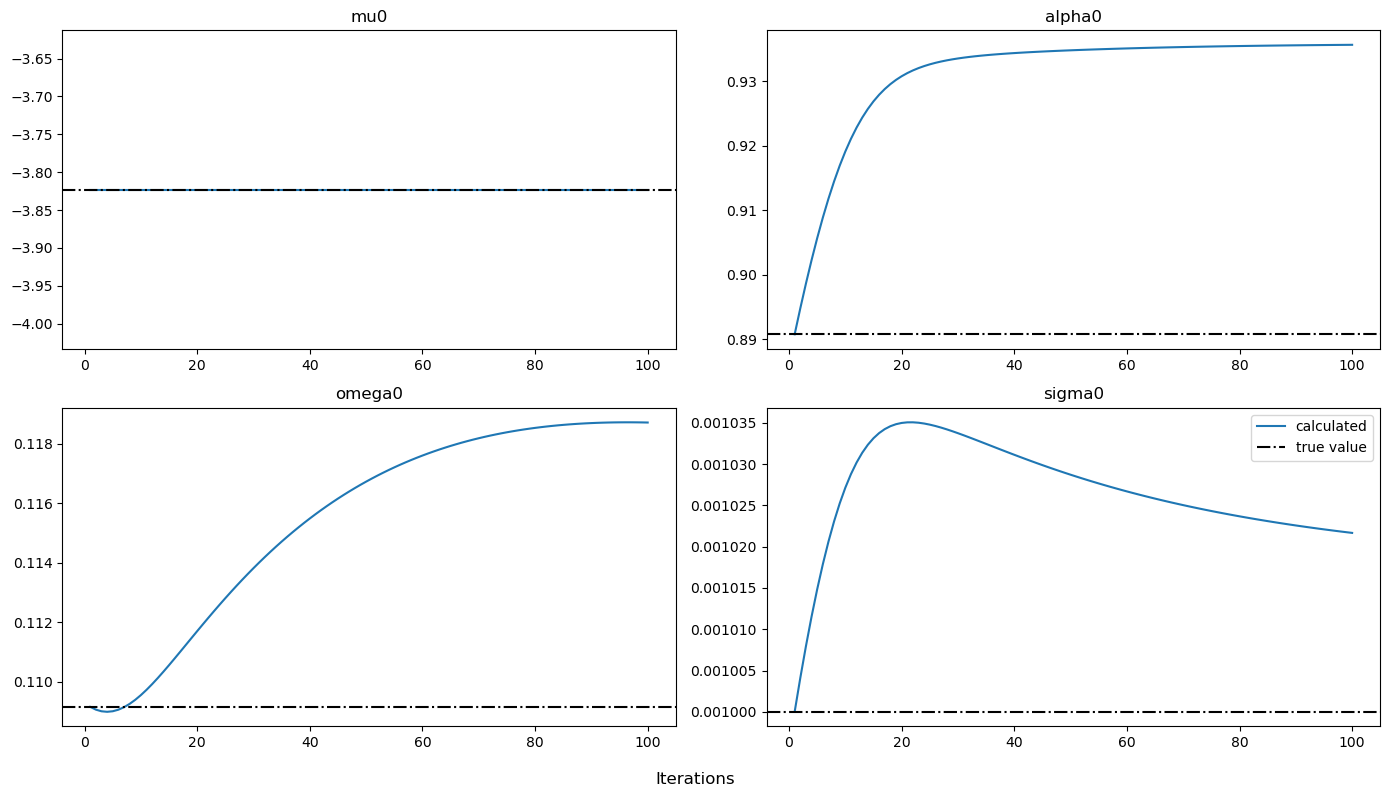

In [30]:
#inits check
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(['mu0', 'alpha0', 'omega0', 'sigma0'], axs.ravel(), true_params, np.arange(4)):
    ax.plot(inits.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


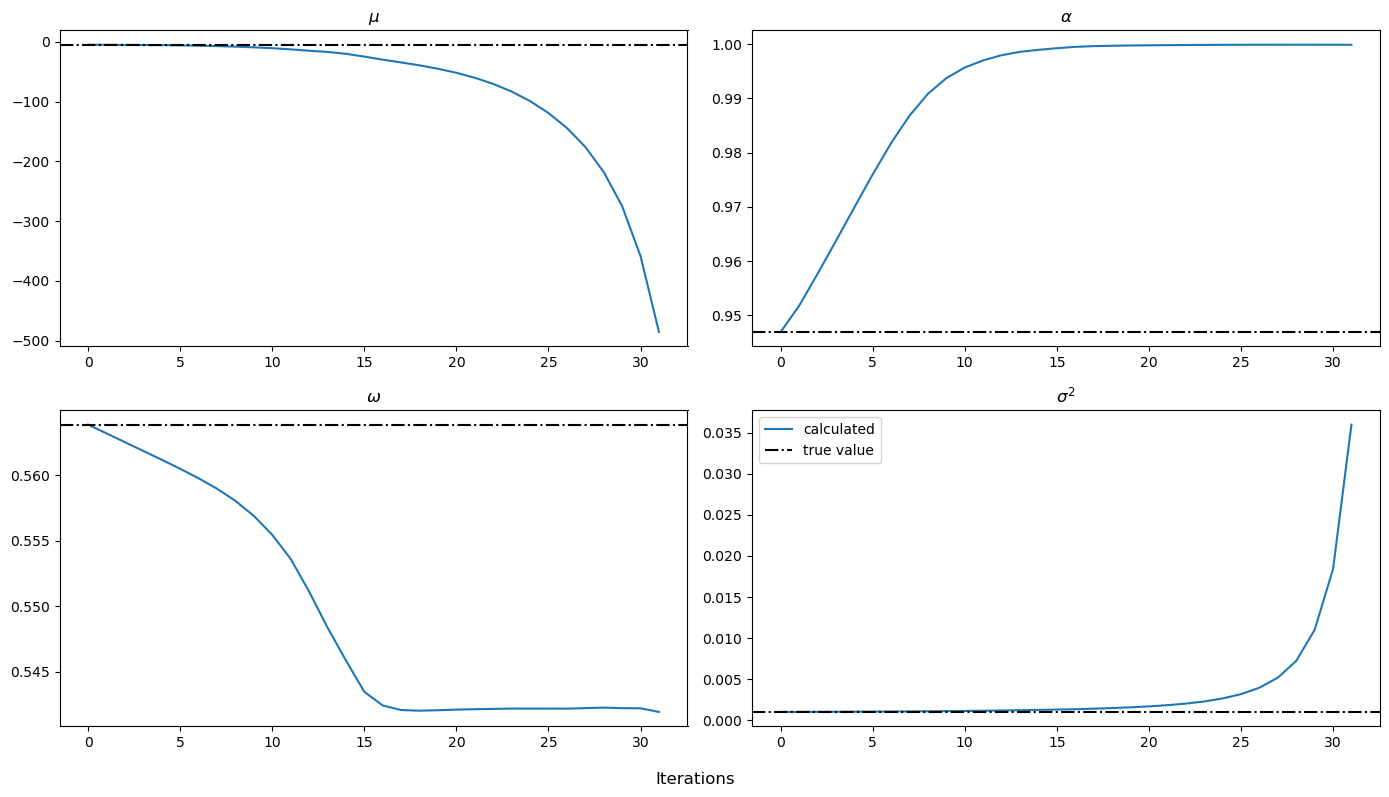

In [16]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


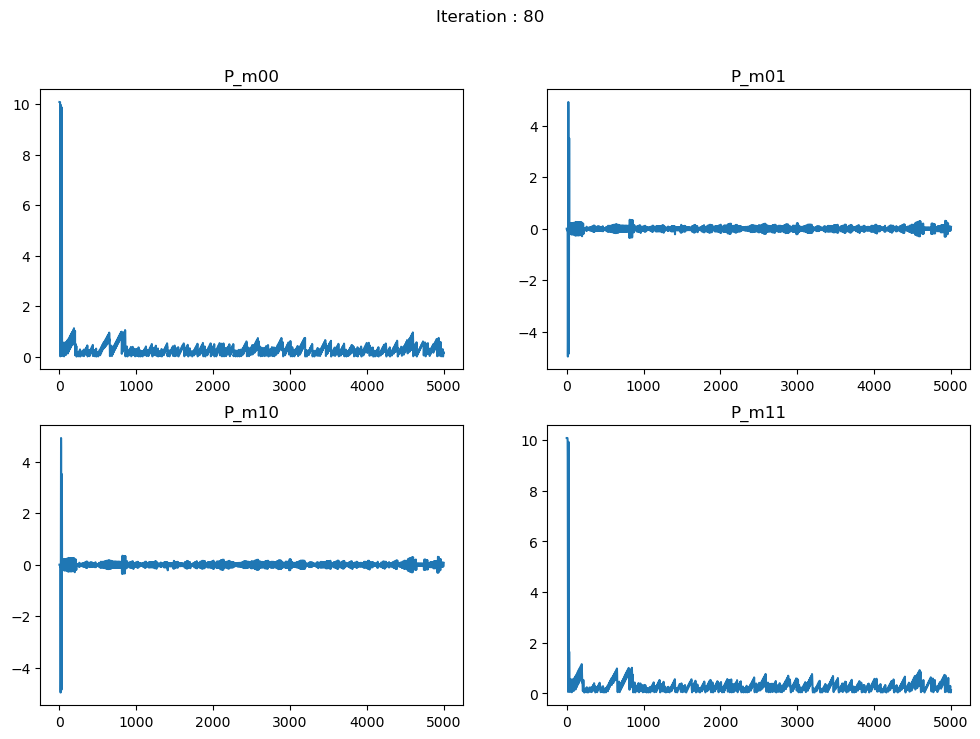

In [79]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 80
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

Text(0.5, 0, 'Iters')

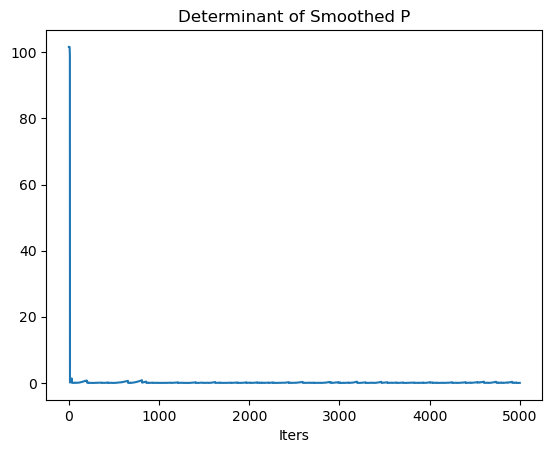

In [80]:
plt.plot(np.linalg.det(E_steps['P_m'][80][..., :].transpose(2,0,1)))
plt.title('Determinant of Smoothed P')
plt.xlabel('Iters')

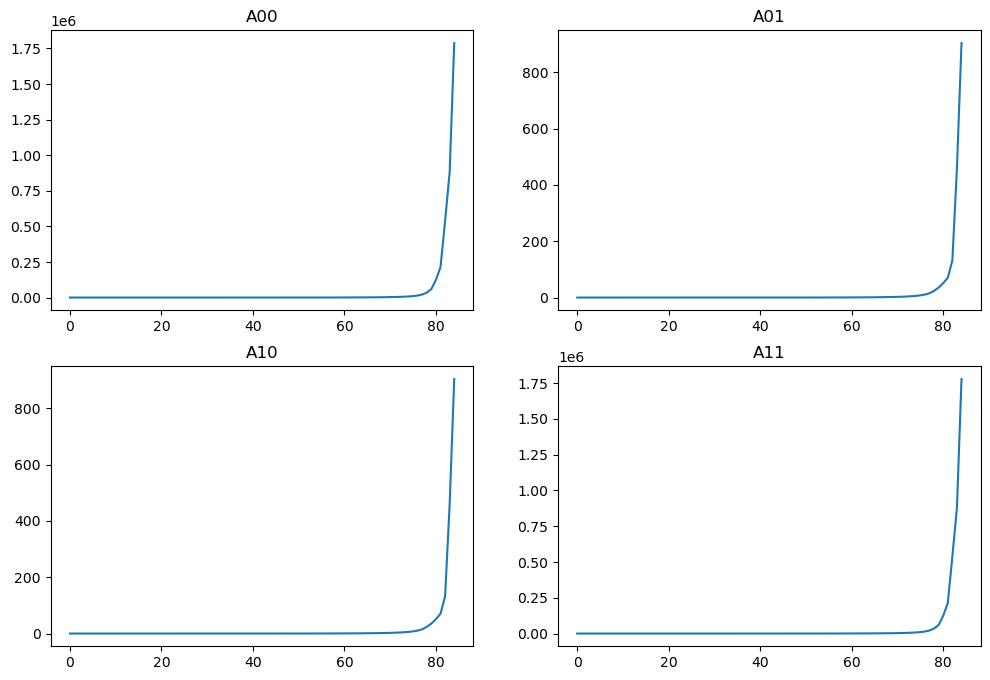

In [67]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'A'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


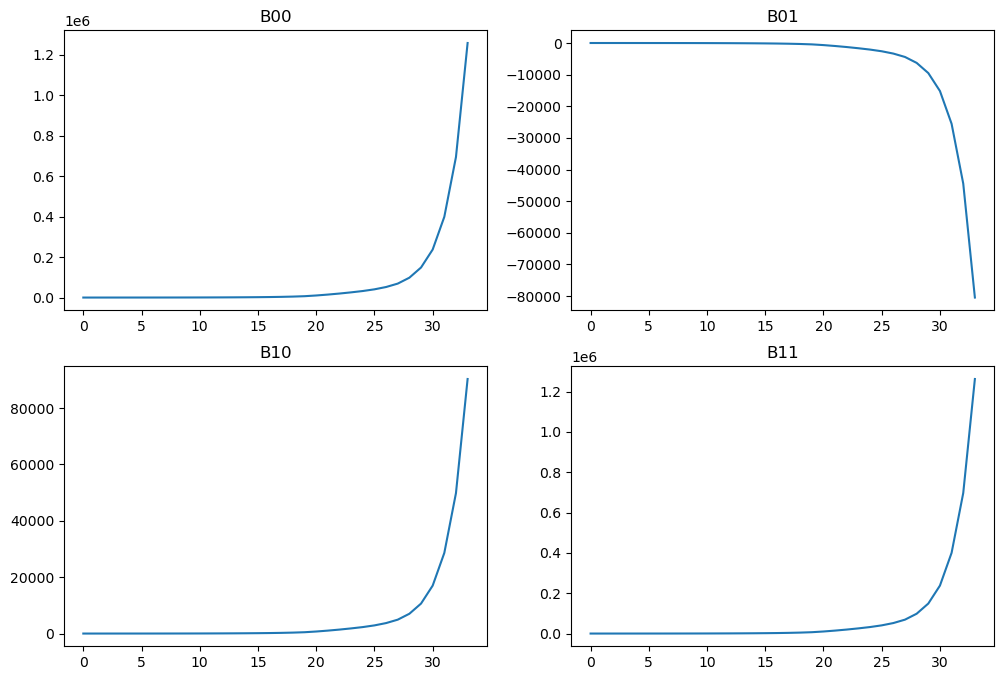

In [57]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'B'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


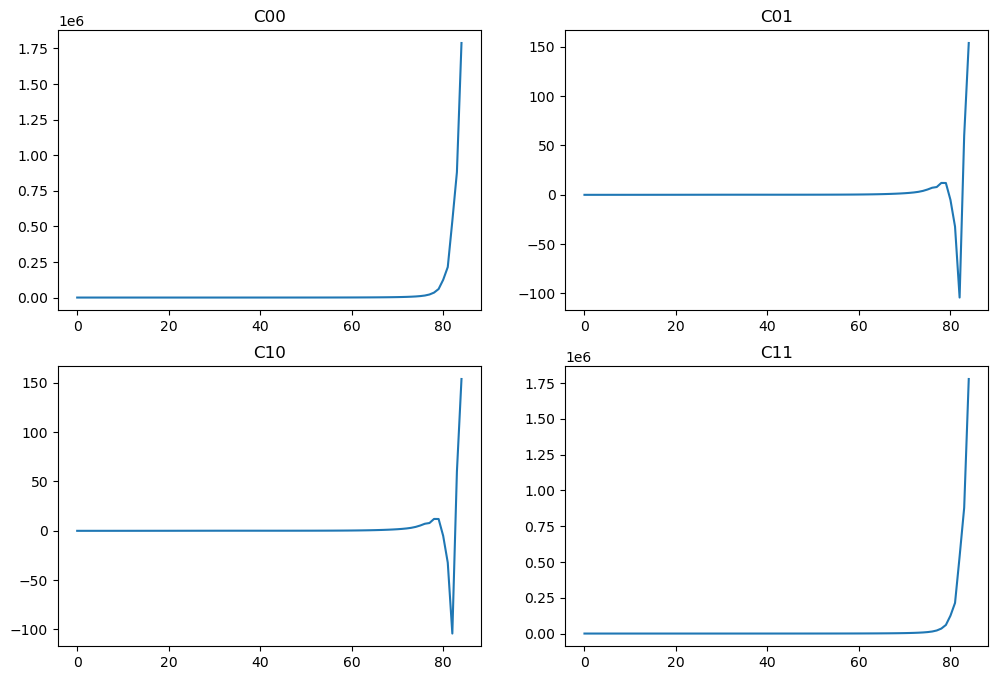

In [68]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'C'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


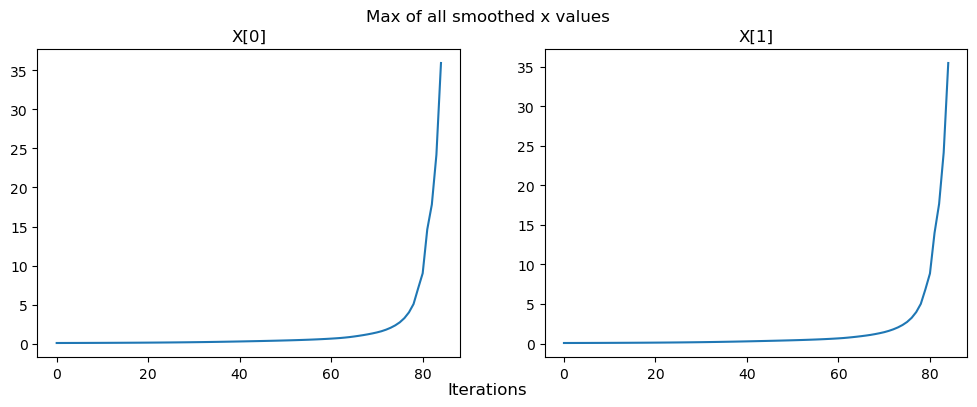

In [69]:
xbs = np.array(E_steps['x_b'])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.plot(xbs[:, 0, :].max(axis=1))
ax1.set_title('X[0]')
ax2.plot(xbs[:, 1, :].max(axis=1))
ax2.set_title('X[1]')
fig.suptitle('Max of all smoothed x values')
fig.supxlabel('Iterations')
plt.show()

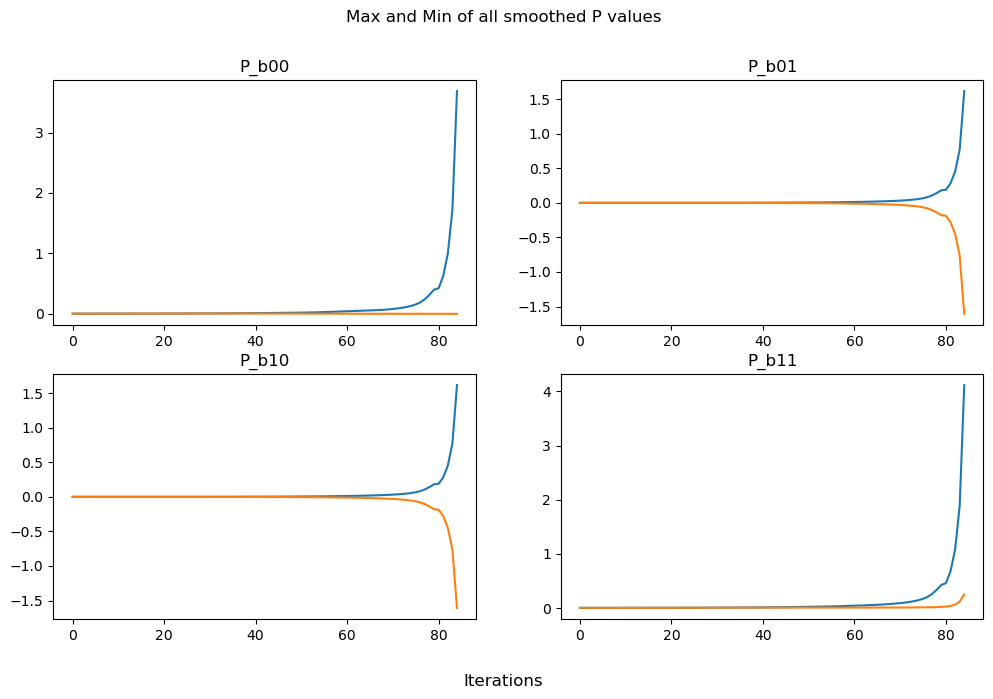

In [72]:
Pbs = np.array(E_steps['P_b'])
fig, axs = plt.subplots(2,2, figsize=(12, 7))

for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(Pbs[:, xx, yy, :].max(axis=1))
        rows.plot(Pbs[:, xx, yy, :].min(axis=1))
        rows.set_title('P_b' + str(xx)+str(yy))

fig.suptitle('Max and Min of all smoothed P values')
fig.supxlabel('Iterations')
plt.show()

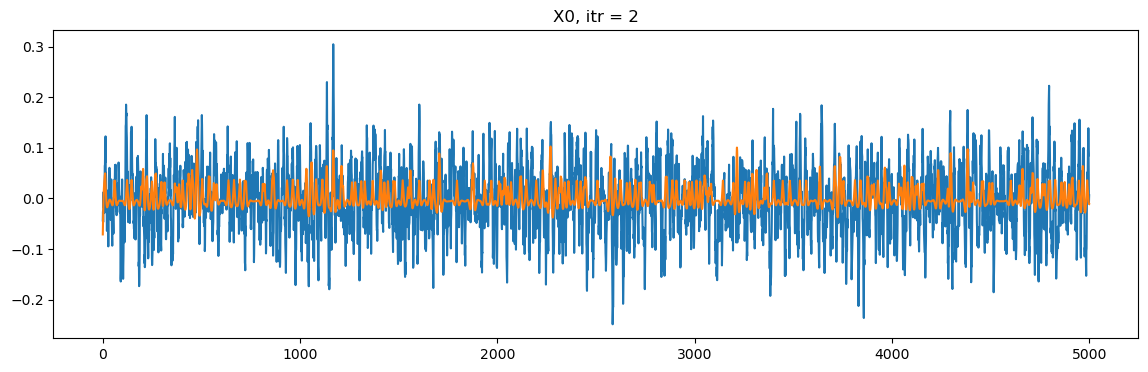

In [73]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][2][0])
plt.title('X0, itr = 2')
plt.show()

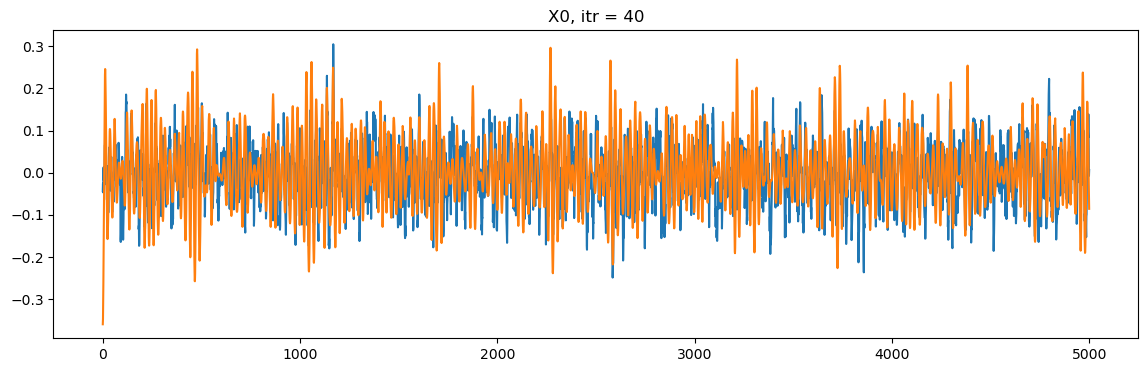

In [77]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][40][0])
plt.title('X0, itr = 40')
plt.show()

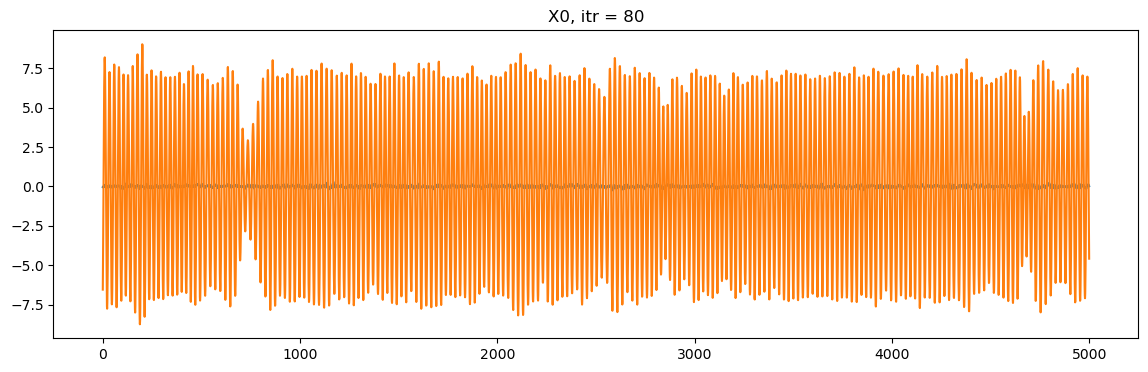

In [75]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][80][0])
plt.title('X0, itr = 80')
plt.show()

## Test N = 5k, no const, with Hess reg

X dims : (2, 5000)
y dims : (5000,)
N : 5000
Fs : 1000
alpha : 0.973
F : 10
omega : 0.0628
sigma : 0.001
mu : -4.5
beta : 8
R : [[ 0.998  -0.0628]
 [ 0.0628  0.998 ]]


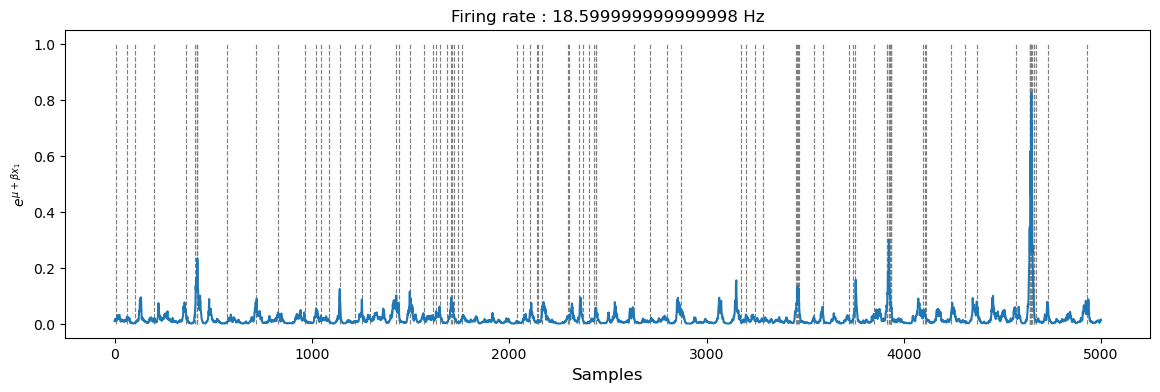

In [12]:
X, y, N, Fs, alpha, F, omega, R, sigma, mu, beta = get_params(N=5000, random = False, print_params=True, plot=True)

In [13]:
mu, beta, sigma, alpha, F


(-4.5, 8, 0.001, 0.973, 10)

In [14]:
# mu0 = -8
# sigma0 = 0.001
# alpha0 = 0.5
# F0 = 5

x0 = X[:, 0]

In [15]:
params, E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu, beta, sigma, alpha, F, Fs,
                                                                           iters = 100, method='trust-krylov')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A b

In [49]:
inits

[]

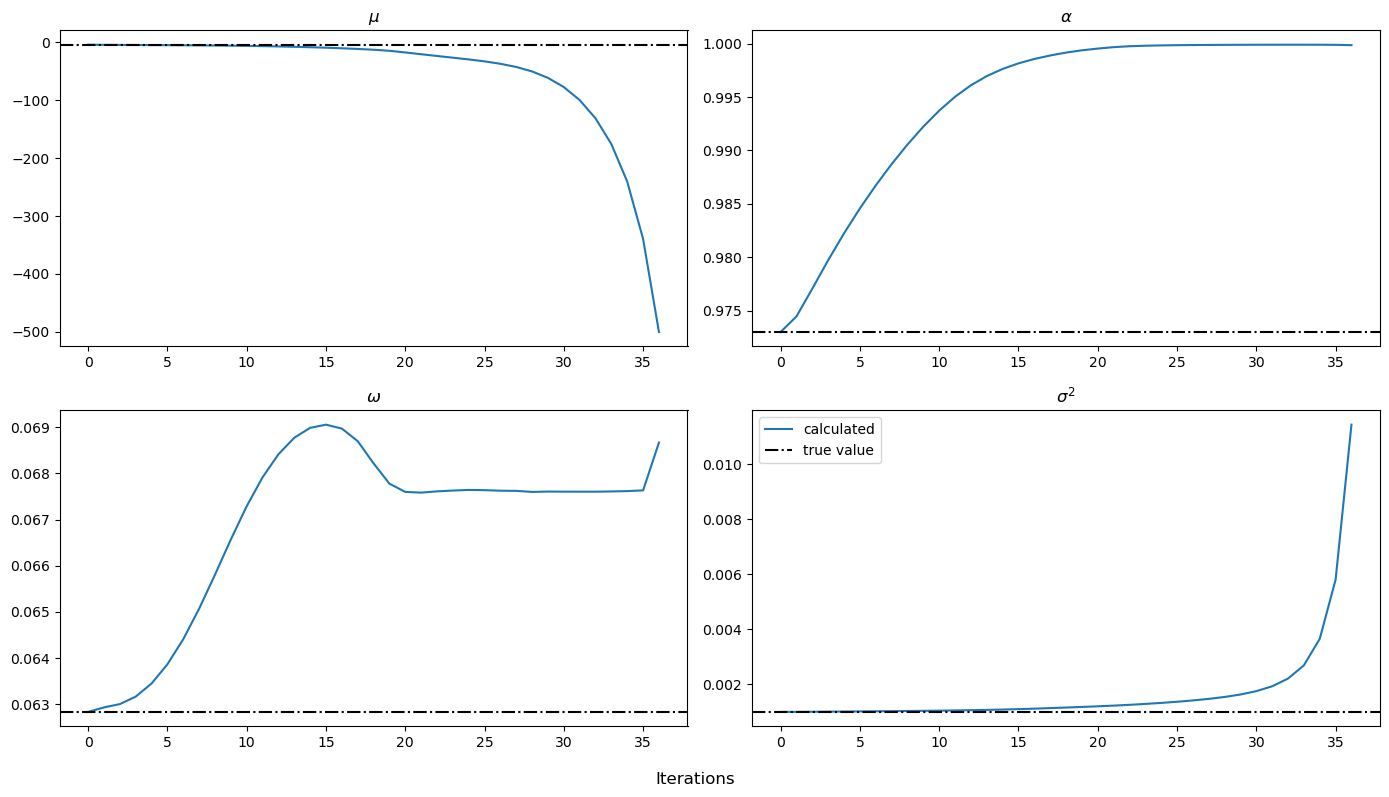

In [16]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params.loc[:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


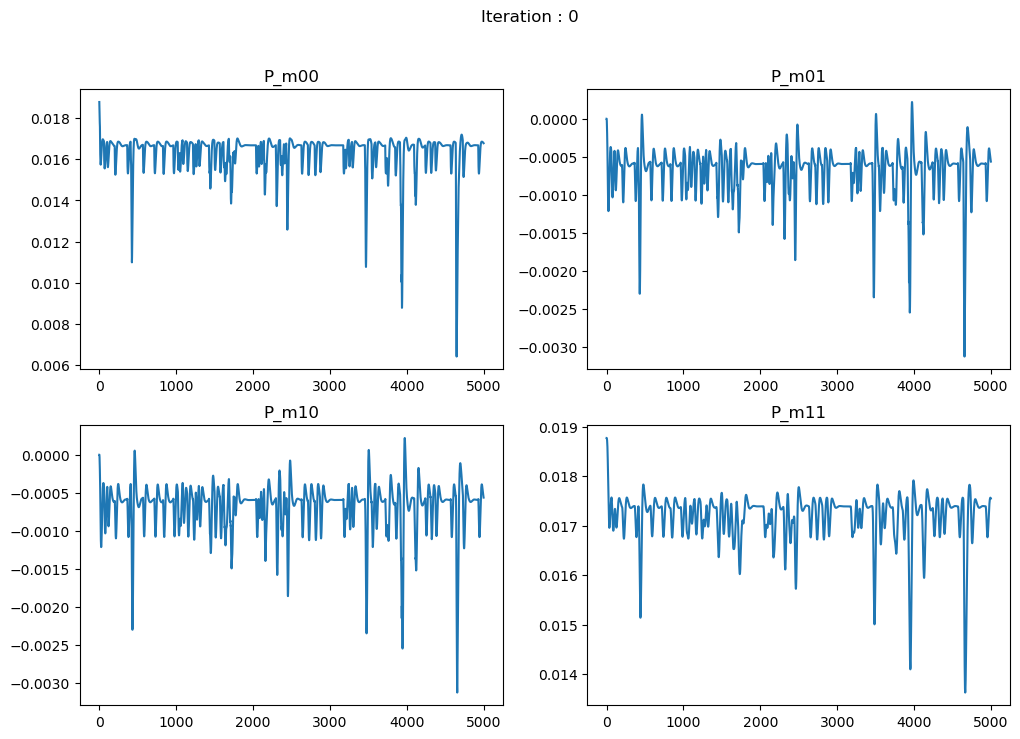

In [18]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 0
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

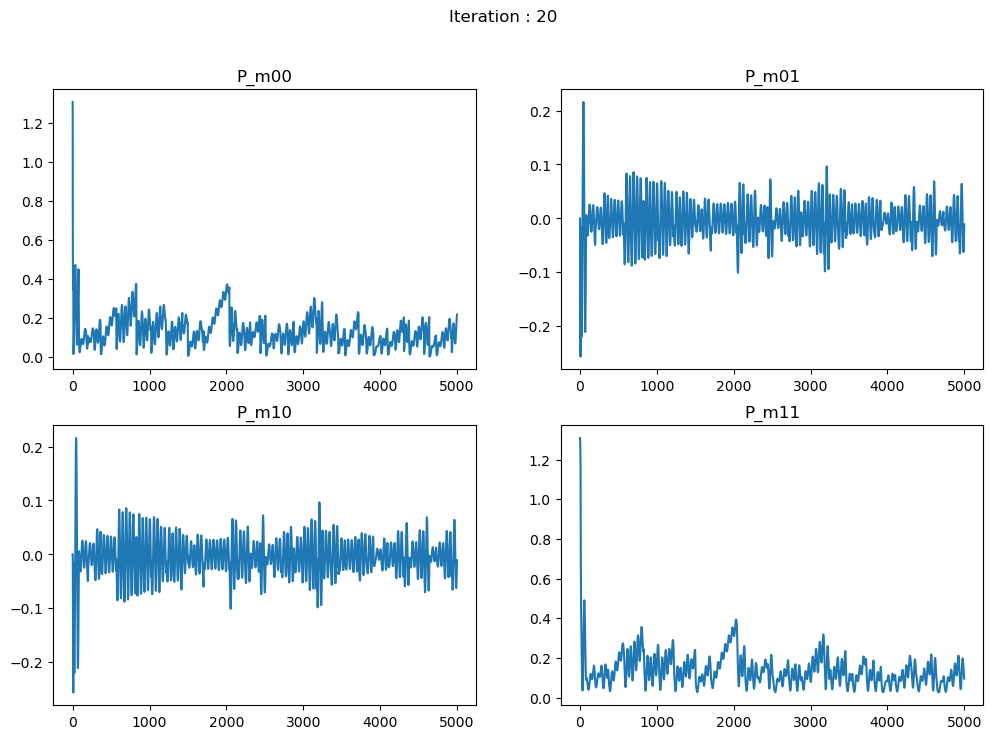

In [19]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 20
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

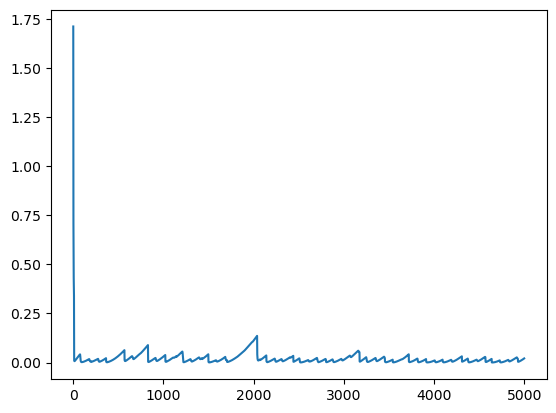

In [22]:
plt.plot(np.linalg.det(E_steps['P_m'][20][..., :].transpose(2,0,1)))

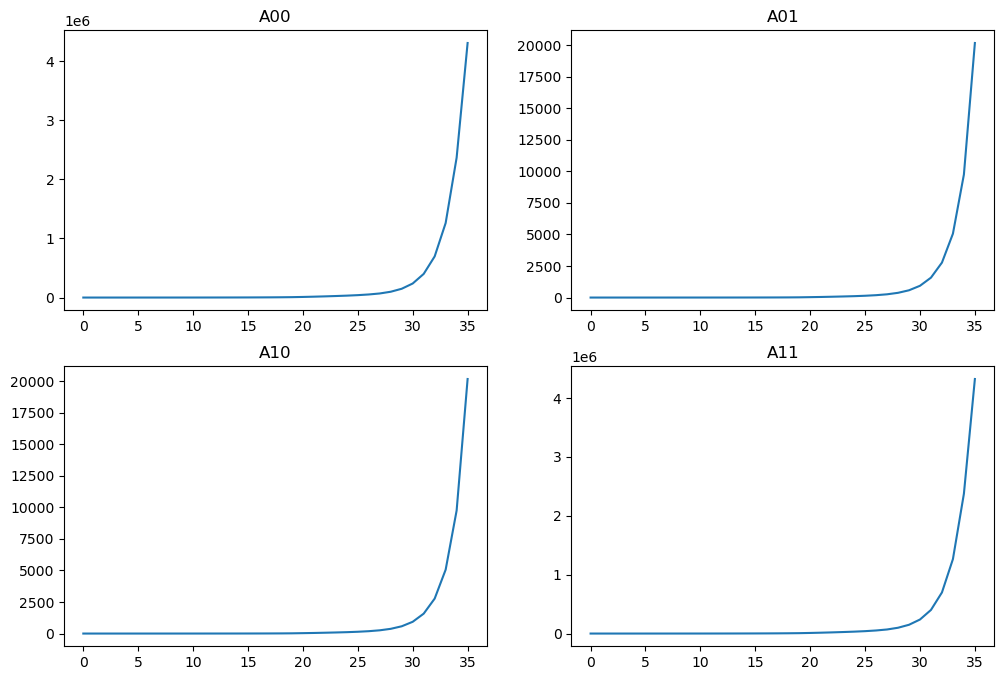

In [24]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'A'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


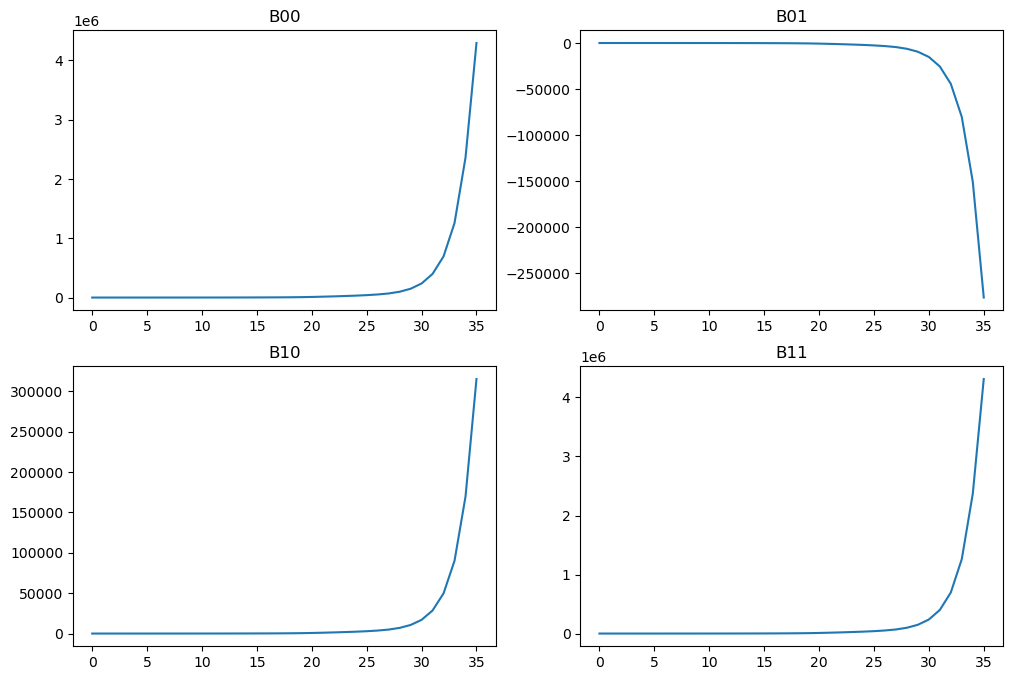

In [25]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'B'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


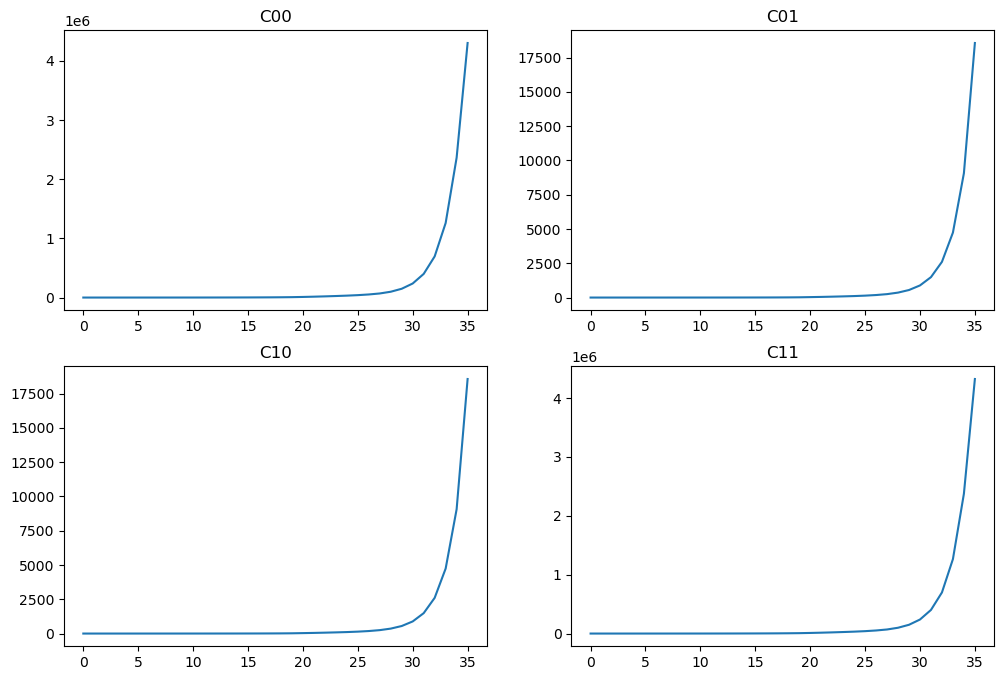

In [26]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'C'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


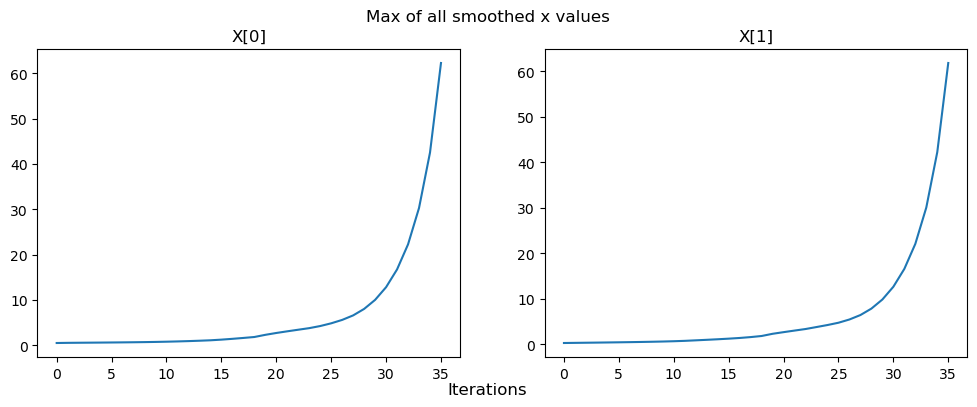

In [27]:
xbs = np.array(E_steps['x_b'])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.plot(xbs[:, 0, :].max(axis=1))
ax1.set_title('X[0]')
ax2.plot(xbs[:, 1, :].max(axis=1))
ax2.set_title('X[1]')
fig.suptitle('Max of all smoothed x values')
fig.supxlabel('Iterations')
plt.show()

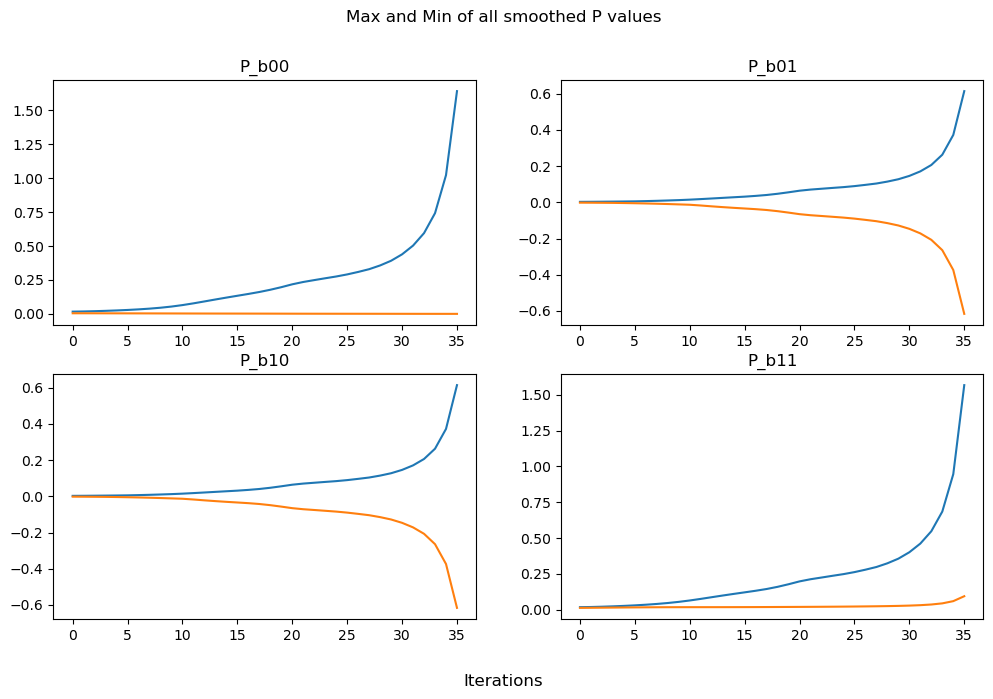

In [28]:
Pbs = np.array(E_steps['P_b'])
fig, axs = plt.subplots(2,2, figsize=(12, 7))

for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(Pbs[:, xx, yy, :].max(axis=1))
        rows.plot(Pbs[:, xx, yy, :].min(axis=1))
        rows.set_title('P_b' + str(xx)+str(yy))

fig.suptitle('Max and Min of all smoothed P values')
fig.supxlabel('Iterations')
plt.show()

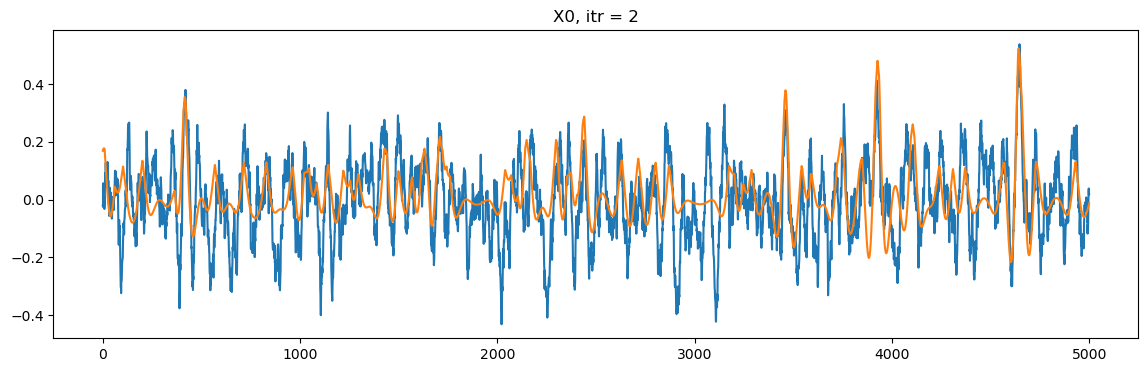

In [29]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][2][0])
plt.title('X0, itr = 2')
plt.show()

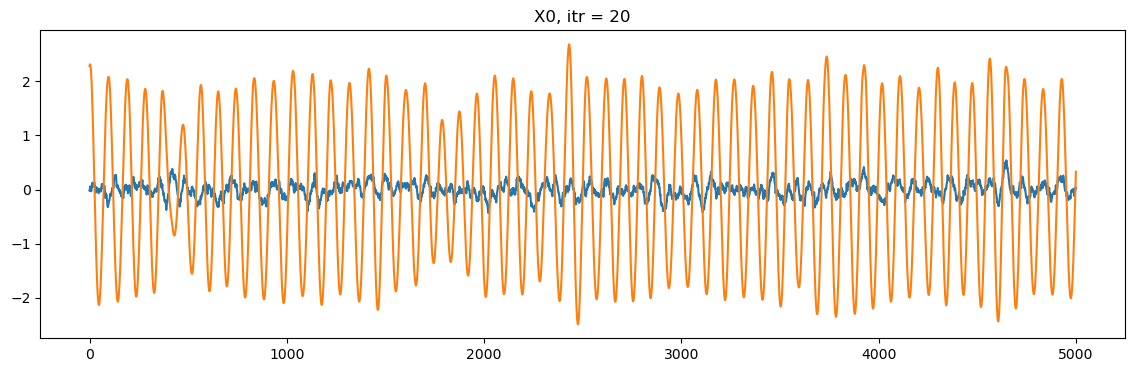

In [30]:
plt.figure(figsize=(14,4))
plt.plot(X[0])

plt.plot(E_steps['x_b'][20][0])
plt.title('X0, itr = 20')
plt.show()

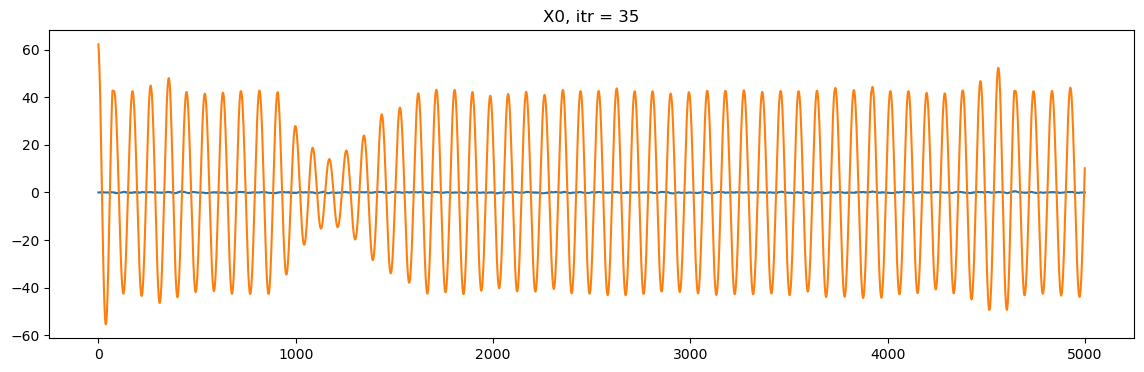

In [31]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][-1][0])
plt.title('X0, itr = 35')
plt.show()

## Test N = 5k, no const, x0 = xp

X dims : (2, 5000)
y dims : (5000,)
N : 5000
Fs : 1000
alpha : 0.99
F : 50
omega : 0.3142
sigma : 0.001
mu : -4
beta : 4.5
R : [[ 0.9511 -0.309 ]
 [ 0.309   0.9511]]


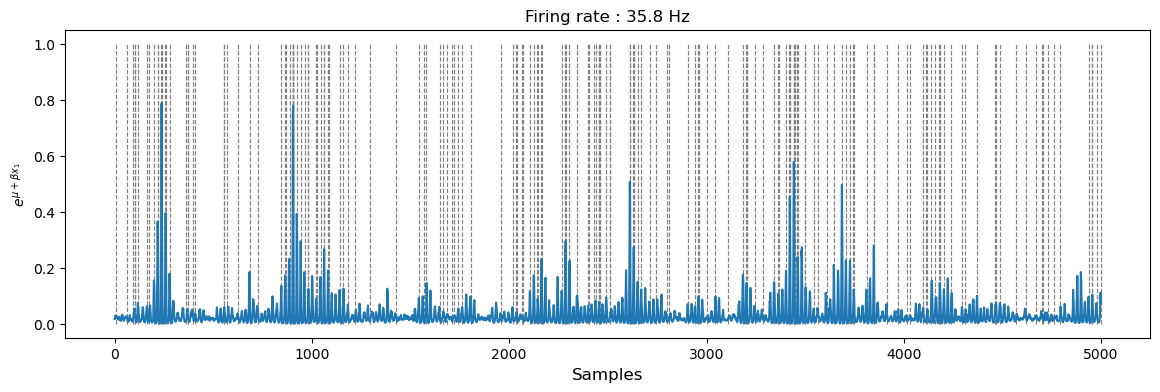

In [89]:
X, y, N, Fs, alpha, F, omega, R, sigma, mu, beta = get_params(N=5000, random = False, print_params=True, plot=True)

In [90]:
mu, beta, sigma, alpha, F


(-4, 4.5, 0.001, 0.99, 50)

In [91]:
# mu0 = -8
# sigma0 = 0.001
# alpha0 = 0.5
# F0 = 5

x0 = X[:, 0]

In [38]:
params, E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log, inits = run_EM(y, x0,
                                                                           mu, beta, sigma, alpha, F, Fs,
                                                                           iters = 100, method='trust-krylov')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict im

In [39]:
inits

[]

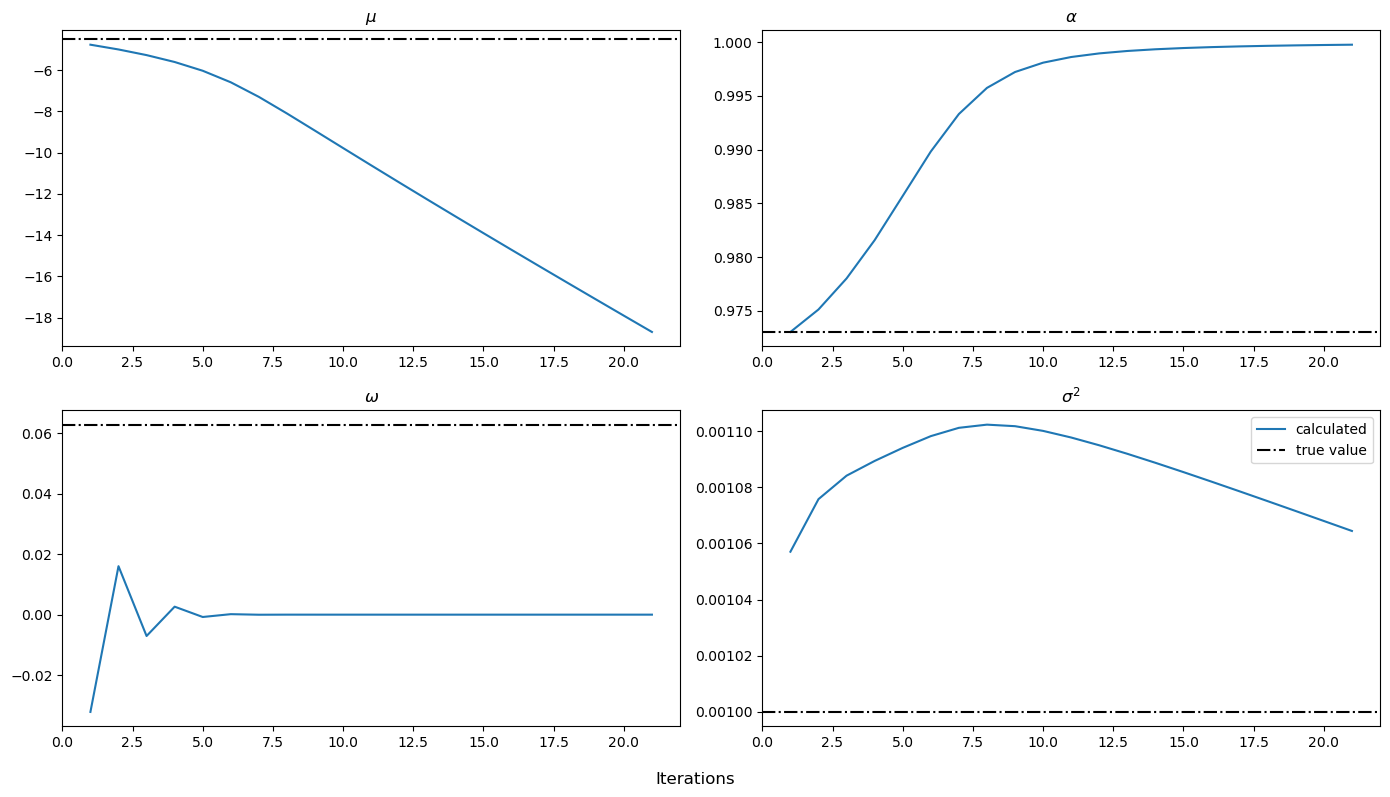

In [40]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
true_params = [mu, alpha, omega, sigma]
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), true_params, np.arange(4)):
    ax.plot(params.loc[1:, cols])
    # ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.axhline(true_param, c='k', ls='-.')
    ax.set_title(cols)
    # ax.set_xlim([75, 90])
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


In [23]:
params

$\mu$  $\alpha$  $\omega$ $\sigma^2$
0       -4.5     0.973  0.062832      0.001
1  -4.761799  0.974458   0.06293   0.001002
2  -4.763016  0.974461  0.063038   0.001002
3  -4.764204  0.974462  0.063154   0.001002
4  -4.765204  0.974462  0.063276   0.001002
5  -4.765955  0.974463  0.063402   0.001002
6  -4.766466  0.974465   0.06353   0.001002
7  -4.766785  0.974468  0.063659   0.001002
8  -4.766962  0.974473   0.06379   0.001002
9  -4.767041  0.974478   0.06392   0.001002
10 -4.767057  0.974483   0.06405   0.001002
11 -4.767032  0.974488   0.06418   0.001002
12 -4.766981  0.974494  0.064308   0.001002
13 -4.766914    0.9745  0.064436   0.001002
14 -4.766839  0.974505  0.064564   0.001002
15 -4.766759  0.974511   0.06469   0.001002
16 -4.766676  0.974517  0.064814   0.001002
17 -4.766592  0.974522  0.064938   0.001002
18 -4.766509  0.974527  0.065061   0.001002
19 -4.766426  0.974533  0.065182   0.001002
20 -4.766345  0.974538  0.065302   0.001002
21 -4.766265  0.974543  0.065421   0.001002
22 -4.766186  0.974548  0.065539   0.001002
23 -4.766109  0.974554  0.065655   0.001002
24 -4.766034  0.974558  0.065769   0.001002
25  -4.76596  0.974563  0.065882   0.001002
26 -4.765888  0.974568  0.065994   0.001002
27 -4.765817  0.974573  0.066105   0.001002
28 -4.765747  0.974578  0.066213   0.001002
29 -4.765679  0.974582  0.066321   0.001002
30 -4.765613  0.974587  0.066426   0.001002
31 -4.765548  0.974591  0.066531   0.001002
32 -4.765484  0.974595  0.066633   0.001002
33 -4.765422    0.9746  0.066734   0.001002
34 -4.765361  0.974604  0.066834   0.001002
35 -4.765301  0.974608  0.066932   0.001002
36 -4.765242  0.974612  0.067028   0.001002
37 -4.765185  0.974616  0.067123   0.001002
38 -4.765129   0.97462  0.067216   0.001002
39 -4.765074  0.974624  0.067308   0.001002
40 -4.765021  0.974627  0.067398   0.001002
41 -4.764968  0.974631  0.067486   0.001002
42 -4.764917  0.974634  0.067573   0.001002
43 -4.764867  0.974638  0.067658   0.001002
44 -4.764818  0.974641  0.067742   0.001002
45  -4.76477  0.974645  0.067824   0.001002
46 -4.764723  0.974648  0.067904   0.001002
47 -4.764677  0.974651  0.067983   0.001002
48 -4.764632  0.974654  0.068061   0.001002
49 -4.764589  0.974657  0.068137   0.001002
50 -4.764546   0.97466  0.068211   0.001002

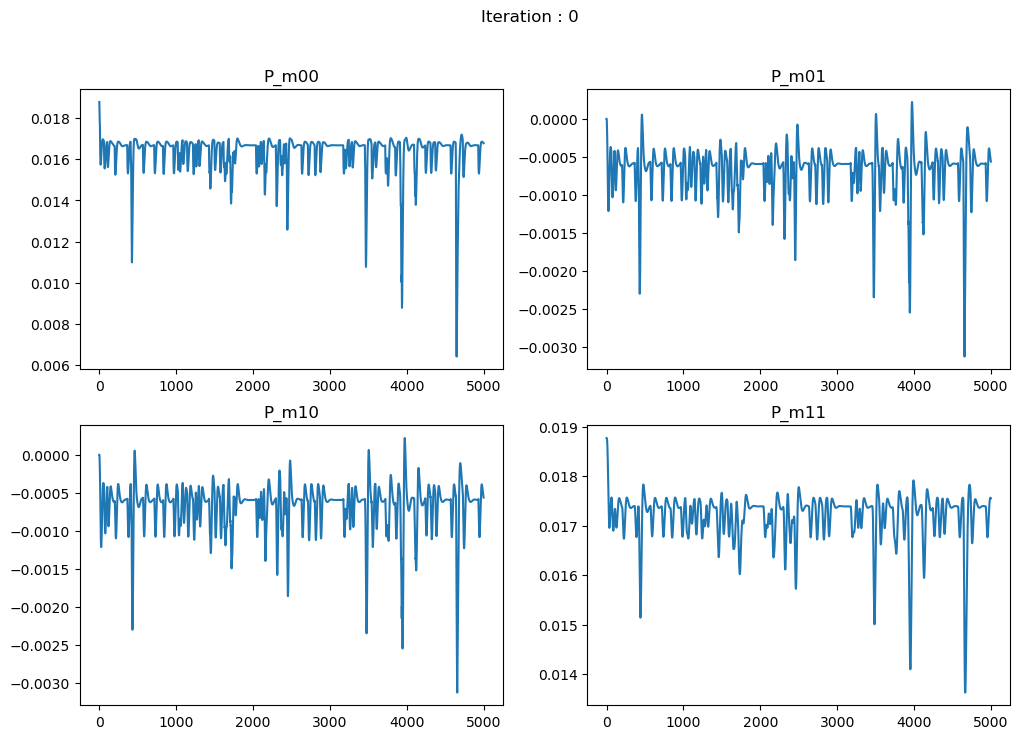

In [89]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 0
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

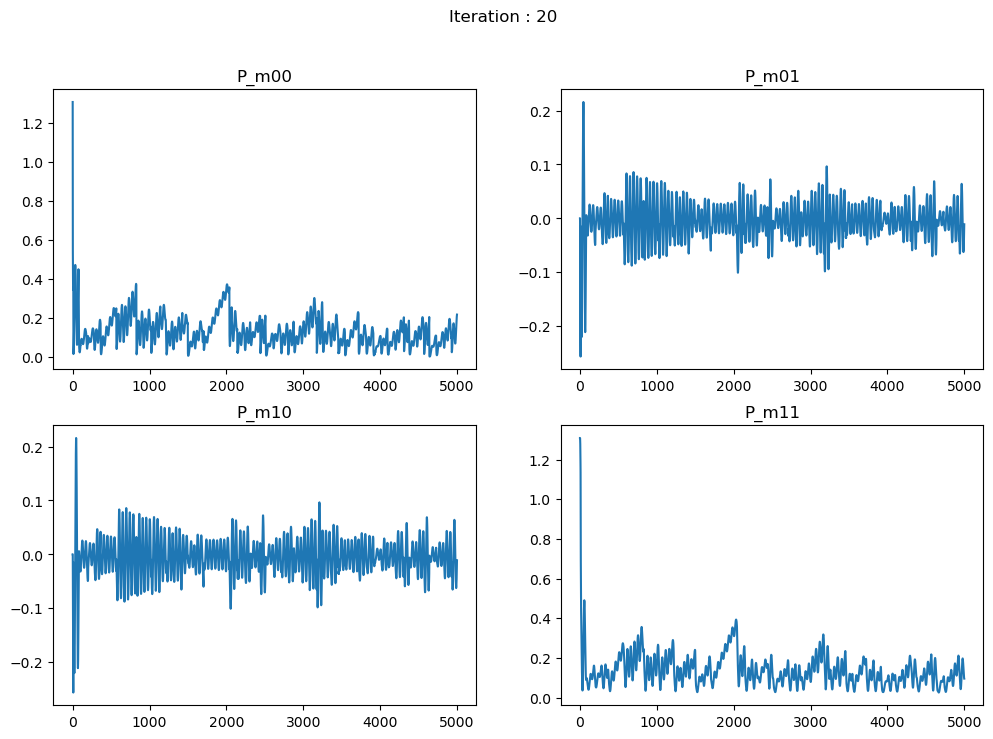

In [90]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

itr= 20
which_E = 'P_m'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        # rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.plot(E_steps[which_E][itr][xx,yy, :])
        rows.set_title(which_E + str(xx)+str(yy))
plt.suptitle(f'Iteration : {itr}')
plt.show()

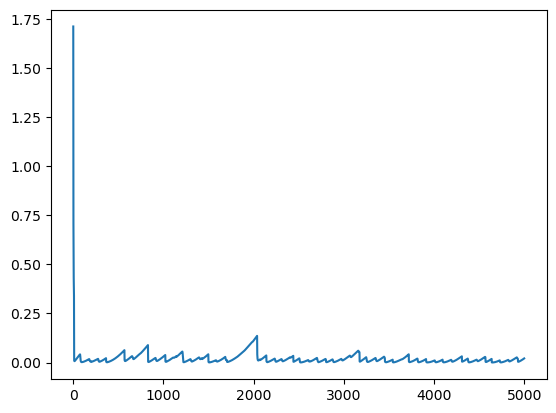

In [22]:
plt.plot(np.linalg.det(E_steps['P_m'][20][..., :].transpose(2,0,1)))

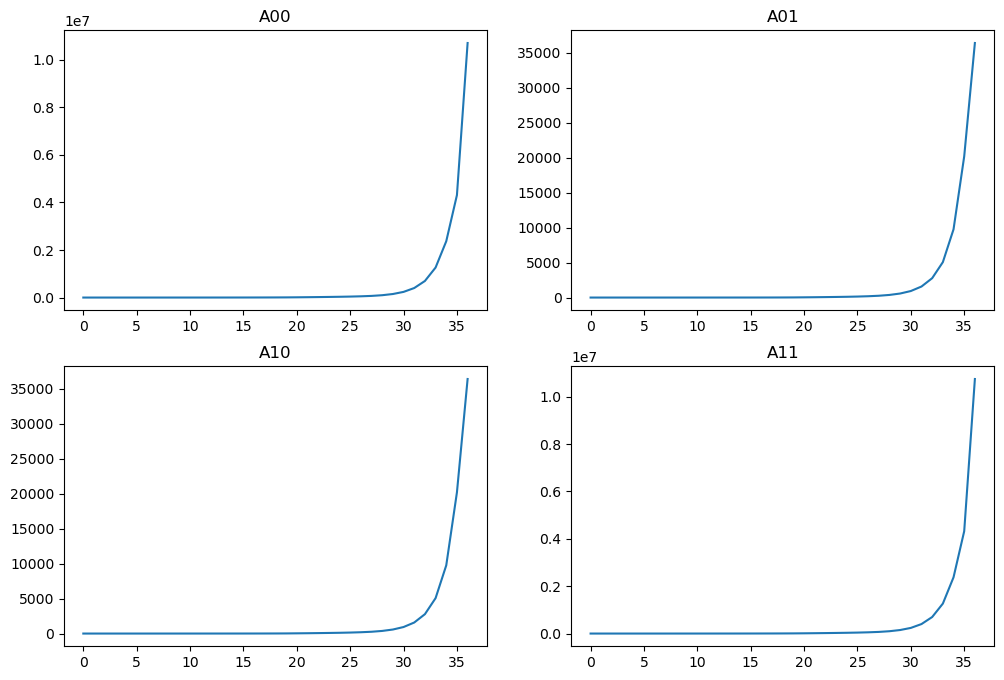

In [91]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'A'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


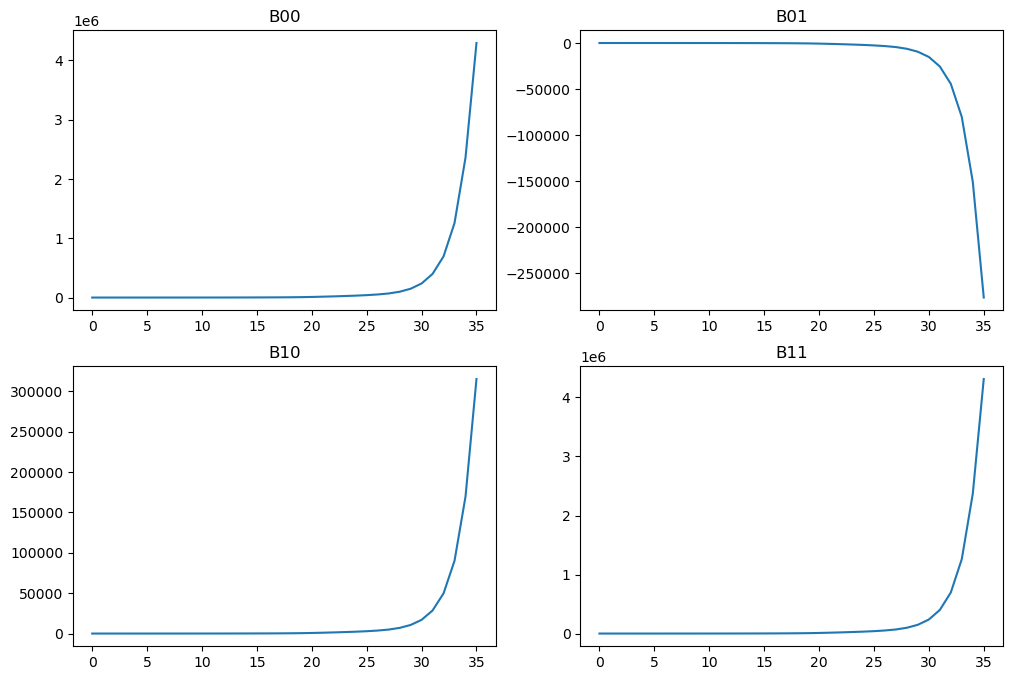

In [25]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'B'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


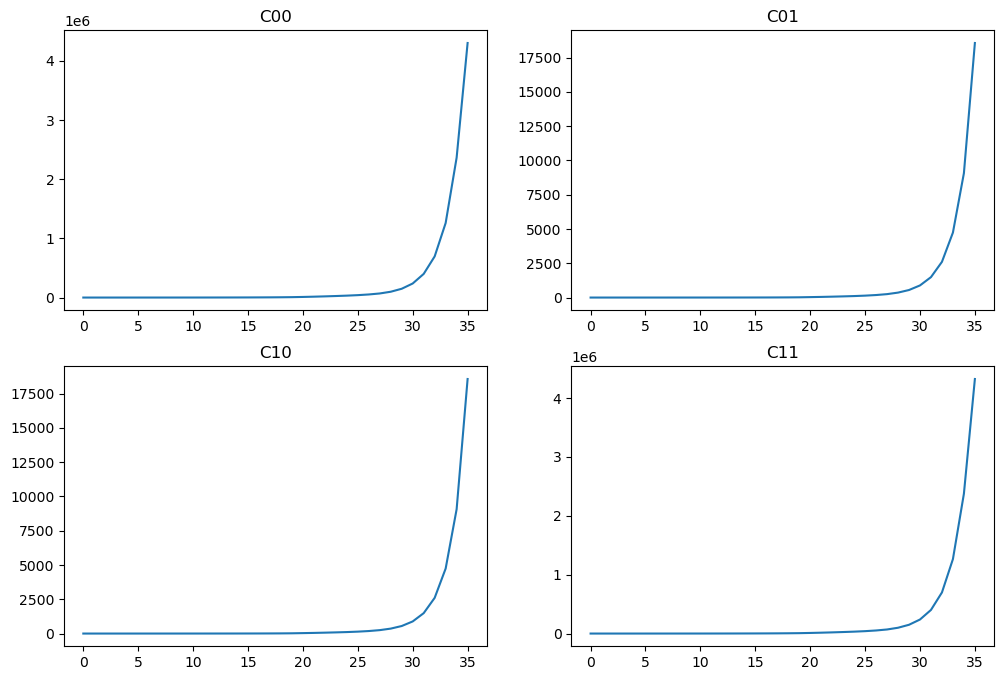

In [26]:

fig, axs = plt.subplots(2,2, figsize=(12,8))

which_E = 'C'
for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(np.array(E_steps[which_E])[:, xx,yy])
        rows.set_title(which_E + str(xx)+str(yy))


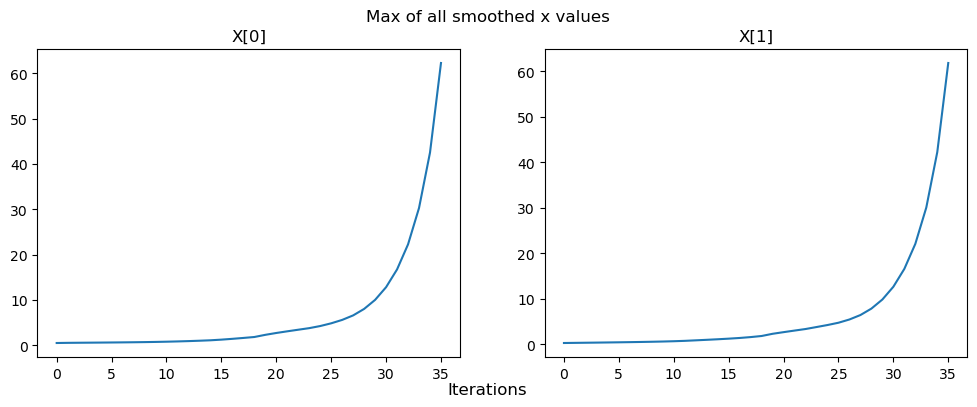

In [27]:
xbs = np.array(E_steps['x_b'])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.plot(xbs[:, 0, :].max(axis=1))
ax1.set_title('X[0]')
ax2.plot(xbs[:, 1, :].max(axis=1))
ax2.set_title('X[1]')
fig.suptitle('Max of all smoothed x values')
fig.supxlabel('Iterations')
plt.show()

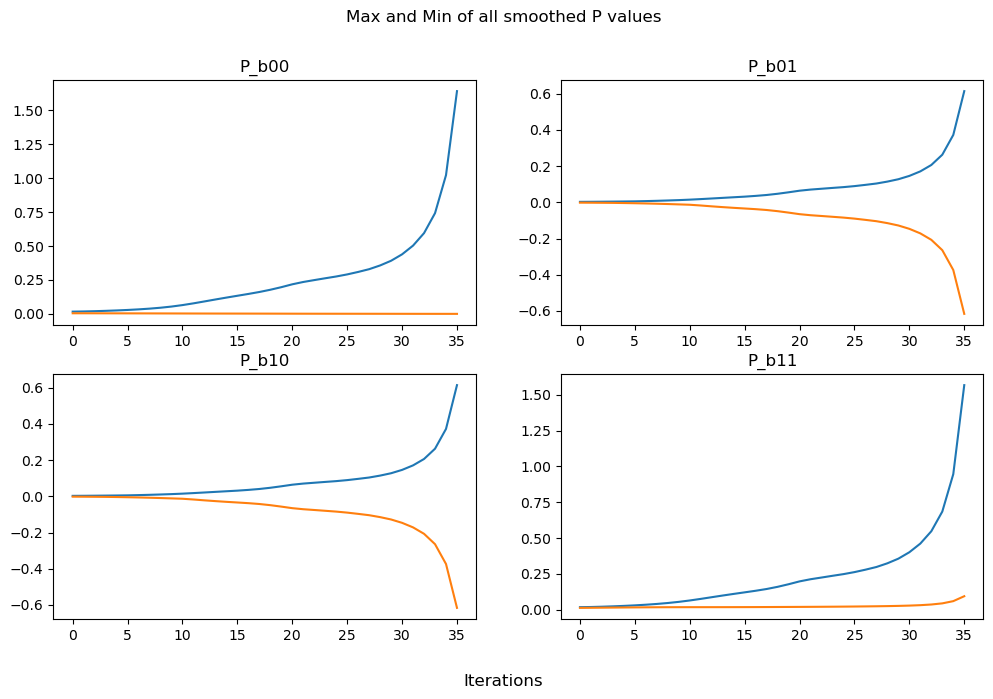

In [28]:
Pbs = np.array(E_steps['P_b'])
fig, axs = plt.subplots(2,2, figsize=(12, 7))

for cols, xx in zip(axs, [0,1]):
    for rows, yy in zip(cols, [0,1]):
        rows.plot(Pbs[:, xx, yy, :].max(axis=1))
        rows.plot(Pbs[:, xx, yy, :].min(axis=1))
        rows.set_title('P_b' + str(xx)+str(yy))

fig.suptitle('Max and Min of all smoothed P values')
fig.supxlabel('Iterations')
plt.show()

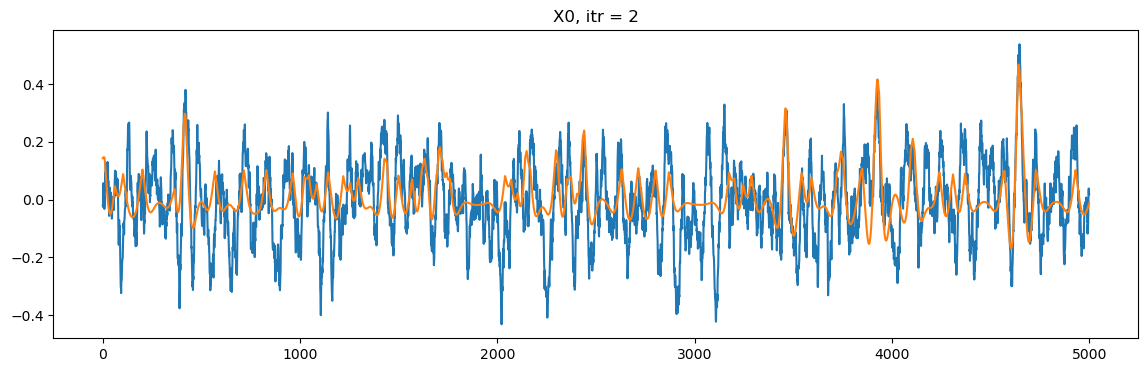

In [24]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][2][0])
plt.title('X0, itr = 2')
plt.show()

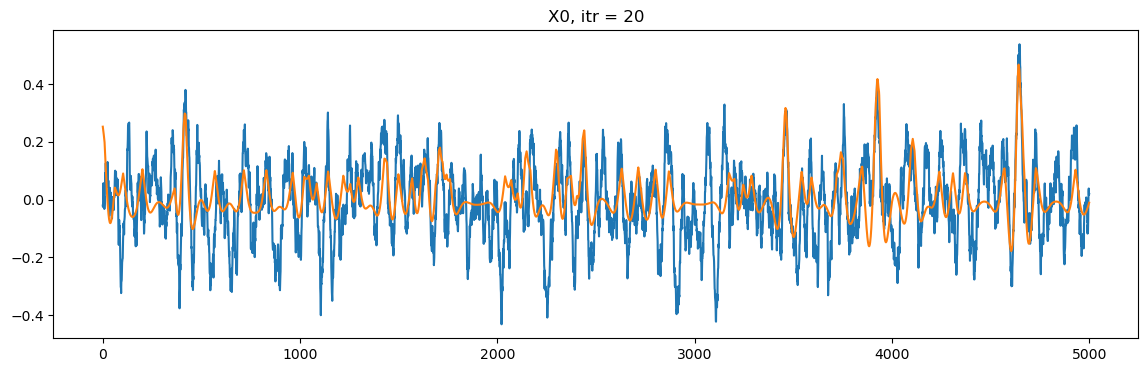

In [25]:
plt.figure(figsize=(14,4))
plt.plot(X[0])

plt.plot(E_steps['x_b'][20][0])
plt.title('X0, itr = 20')
plt.show()

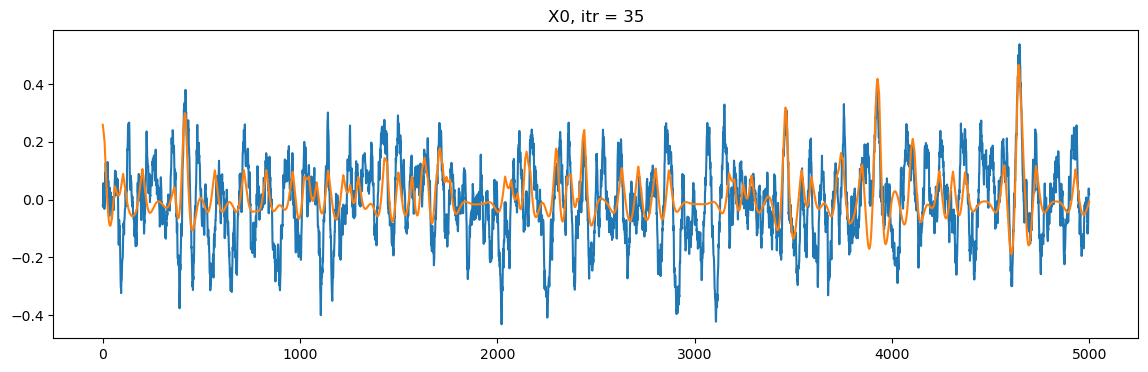

In [26]:
plt.figure(figsize=(14,4))
plt.plot(X[0])
plt.plot(E_steps['x_b'][-1][0])
plt.title('X0, itr = 35')
plt.show()